#Import libraries

In [2]:
# Import nessesery libraries
import pandas as pd
from pandas import json_normalize
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from datetime import datetime
import seaborn as sns
import math
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.stats import pearsonr
from scipy.stats import f_oneway
import itertools

#Import Data

In [3]:
# To import csv files, you have to go to "Files" (button is on a left side), then "Upload to session storage" and choose both files

datapoints = pd.read_csv("/content/datapoints-ssp-mock2.csv")
segments = pd.read_csv("/content/segments-ssp-mock2.csv")

print(datapoints)
print(segments)

          id  segment_id           time_index  view_count  \
0          1         379  2022-01-01 00:00:00         177   
1          2         379  2022-01-01 01:00:00         135   
2          3         379  2022-01-01 02:00:00          26   
3          4         379  2022-01-01 03:00:00         159   
4          5         379  2022-01-01 04:00:00          50   
...      ...         ...                  ...         ...   
95521  95522          77  2022-11-27 01:00:00         240   
95522  95523          77  2022-11-27 02:00:00         242   
95523  95524          77  2022-11-27 03:00:00         207   
95524  95525          77  2022-11-27 04:00:00         257   
95525  95526          77  2022-11-27 05:00:00         196   

                                                 devices  
0      {"windows": 120, "android": 7, "mac os x": 37,...  
1      {"windows": 92, "android": 5, "mac os x": 28, ...  
2      {"windows": 18, "android": 1, "mac os x": 5, "...  
3      {"windows": 108, "androi

In [4]:
#Check N/A value
datapoints.isnull().values.any()

False

In [5]:
#Check unique values in segment_id column
datapoints['segment_id'].unique()

array([379,  52,  53,  90,  58, 483, 210, 150, 176, 492,  77])

As we can see there is no data for Music and Food & Drink

In [6]:
#Look at data types in dataframe
datapoints.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95526 entries, 0 to 95525
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          95526 non-null  int64 
 1   segment_id  95526 non-null  int64 
 2   time_index  95526 non-null  object
 3   view_count  95526 non-null  int64 
 4   devices     95526 non-null  object
dtypes: int64(3), object(2)
memory usage: 3.6+ MB


Can see 5 columns: index column, id, segment_id, time_index, view_count, devices.

First want to remove. Segment_id want to merge with segment.csv to get column with names of segments. Time_index type change from object to datetime64. View_counts is correct. Devices - take data from dictioneries

#Preprocessing Data

In [7]:
#Remove id column
datapoints = datapoints.drop(['id'], axis = 1)

#Marge segment_id with segment_name from segment.csv
datapoints = pd.merge(left=datapoints, right=segments, how='left')
datapoints = datapoints.drop(['segment_id'], axis = 1)

#Change date type format
datapoints['time_index'] = pd.to_datetime(datapoints['time_index'])

datapoints

time_index  view_count  \
0     2022-01-01 00:00:00         177   
1     2022-01-01 01:00:00         135   
2     2022-01-01 02:00:00          26   
3     2022-01-01 03:00:00         159   
4     2022-01-01 04:00:00          50   
...                   ...         ...   
95521 2022-11-27 01:00:00         240   
95522 2022-11-27 02:00:00         242   
95523 2022-11-27 03:00:00         207   
95524 2022-11-27 04:00:00         257   
95525 2022-11-27 05:00:00         196   

                                                 devices  \
0      {"windows": 120, "android": 7, "mac os x": 37,...   
1      {"windows": 92, "android": 5, "mac os x": 28, ...   
2      {"windows": 18, "android": 1, "mac os x": 5, "...   
3      {"windows": 108, "android": 6, "mac os x": 33,...   
4      {"windows": 34, "android": 2, "mac os x": 10, ...   
...                                                  ...   
95521  {"windows": 110, "android": 12, "mac os x": 94...   
95522  {"windows": 111, "android": 12, "mac os x": 94...   
95523  {"windows": 95, "android": 10, "mac os x": 81,...   
95524  {"windows": 118, "android": 13, "mac os x": 10...   
95525  {"windows": 90, "android": 10, "mac os x": 76,...   

                 segment_name  
0      Technology & Computing  
1      Technology & Computing  
2      Technology & Computing  
3      Technology & Computing  
4      Technology & Computing  
...                       ...  
95521                    Pets  
95522                    Pets  
95523                    Pets  
95524                    Pets  
95525                    Pets  

[95526 rows x 4 columns]

In [8]:
# Look at 'device' column type
datapoints['devices']

0        {"windows": 120, "android": 7, "mac os x": 37,...
1        {"windows": 92, "android": 5, "mac os x": 28, ...
2        {"windows": 18, "android": 1, "mac os x": 5, "...
3        {"windows": 108, "android": 6, "mac os x": 33,...
4        {"windows": 34, "android": 2, "mac os x": 10, ...
                               ...                        
95521    {"windows": 110, "android": 12, "mac os x": 94...
95522    {"windows": 111, "android": 12, "mac os x": 94...
95523    {"windows": 95, "android": 10, "mac os x": 81,...
95524    {"windows": 118, "android": 13, "mac os x": 10...
95525    {"windows": 90, "android": 10, "mac os x": 76,...
Name: devices, Length: 95526, dtype: object

As we can see column 'device' is an object with strings as a value.

So we have to change string to dictionary, then normalize to dataframe and marge with rest of data

In [9]:
# Set 'device' column as a dataframe
devices = pd.DataFrame(datapoints['devices'])

# Function to convert a string to a dictionary
def string_to_dict(s):
    return eval(s) if isinstance(s, str) else {}

# Apply the function to each cell in the DataFrame
devices1 = devices.applymap(string_to_dict)

# Display the updated DataFrame
devices1

devices
0      {'windows': 120, 'android': 7, 'mac os x': 37,...
1      {'windows': 92, 'android': 5, 'mac os x': 28, ...
2      {'windows': 18, 'android': 1, 'mac os x': 5, '...
3      {'windows': 108, 'android': 6, 'mac os x': 33,...
4      {'windows': 34, 'android': 2, 'mac os x': 10, ...
...                                                  ...
95521  {'windows': 110, 'android': 12, 'mac os x': 94...
95522  {'windows': 111, 'android': 12, 'mac os x': 94...
95523  {'windows': 95, 'android': 10, 'mac os x': 81,...
95524  {'windows': 118, 'android': 13, 'mac os x': 10...
95525  {'windows': 90, 'android': 10, 'mac os x': 76,...

[95526 rows x 1 columns]

In [10]:
# Use json_normalize to create separate columns for the dictionaries
normalized_devices = json_normalize(devices1['devices'])

# Combine the normalized DataFrame with the original DataFrame
result_devices = pd.concat([devices, normalized_devices], axis=1)

#Create value for Mobile column
mobile = result_devices['android'] + result_devices['iphone']

#Create value for Desktop column
desktop = result_devices['windows'] + result_devices['mac os x']

# Combine the normalized DataFrame with the original DataFrame
datapoints_merged = pd.concat([datapoints, result_devices], axis=1)
datapoints_merged['mobile'] = mobile
datapoints_merged['desktop'] = desktop

datapoints = datapoints_merged.drop('devices', axis=1)

#Change segment_name data type to string
datapoints = datapoints.astype({'segment_name':'string'})

datapoints

time_index  view_count            segment_name  windows  \
0     2022-01-01 00:00:00         177  Technology & Computing      120   
1     2022-01-01 01:00:00         135  Technology & Computing       92   
2     2022-01-01 02:00:00          26  Technology & Computing       18   
3     2022-01-01 03:00:00         159  Technology & Computing      108   
4     2022-01-01 04:00:00          50  Technology & Computing       34   
...                   ...         ...                     ...      ...   
95521 2022-11-27 01:00:00         240                    Pets      110   
95522 2022-11-27 02:00:00         242                    Pets      111   
95523 2022-11-27 03:00:00         207                    Pets       95   
95524 2022-11-27 04:00:00         257                    Pets      118   
95525 2022-11-27 05:00:00         196                    Pets       90   

       android  mac os x  iphone  other  mobile  desktop  
0            7        37       9      2      16      157  
1            5        28       7      1      12      120  
2            1         5       1      0       2       23  
3            6        33       8      2      14      141  
4            2        10       2      0       4       44  
...        ...       ...     ...    ...     ...      ...  
95521       12        94      19      5      31      204  
95522       12        94      19      5      31      205  
95523       10        81      17      4      27      176  
95524       13       100      21      5      34      218  
95525       10        76      16      4      26      166  

[95526 rows x 10 columns]

In [11]:
datapoints.describe()

view_count       windows       android      mac os x        iphone  \
count  95526.000000  95526.000000  95526.000000  95526.000000  95526.000000   
mean    1257.967527    865.168980     47.649195    261.582690     60.476582   
std     1504.672021   1036.010017     59.390485    309.851444     74.242968   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%      227.000000    141.000000      8.000000     58.000000     12.000000   
50%      615.000000    445.000000     20.000000    120.000000     25.000000   
75%     1955.000000   1351.000000     72.000000    397.000000     92.000000   
max    15963.000000  10855.000000    639.000000   3352.000000    798.000000   

              other        mobile       desktop  
count  95526.000000  95526.000000  95526.000000  
mean      13.617277    108.125777   1126.751670  
std       15.030967    133.616230   1344.170859  
min        0.000000      0.000000      0.000000  
25%        3.000000     20.000000    200.000000  
50%        8.000000     45.000000    561.000000  
75%       21.000000    164.000000   1752.000000  
max      160.000000   1437.000000  14207.000000

In [12]:
datapoints.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95526 entries, 0 to 95525
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   time_index    95526 non-null  datetime64[ns]
 1   view_count    95526 non-null  int64         
 2   segment_name  95526 non-null  string        
 3   windows       95526 non-null  int64         
 4   android       95526 non-null  int64         
 5   mac os x      95526 non-null  int64         
 6   iphone        95526 non-null  int64         
 7   other         95526 non-null  int64         
 8   mobile        95526 non-null  int64         
 9   desktop       95526 non-null  int64         
dtypes: datetime64[ns](1), int64(8), string(1)
memory usage: 8.0 MB


In [ ]:
#Download dataset to csv file
datapoints.to_csv("datapoints.csv")

#Sesonality

Find any seasonality that can be observed affecting the segments when it comes to
views.

<ipython-input-13-30cd2e494eab>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resampled_data = datapoints.resample('D', on='time_index').sum()


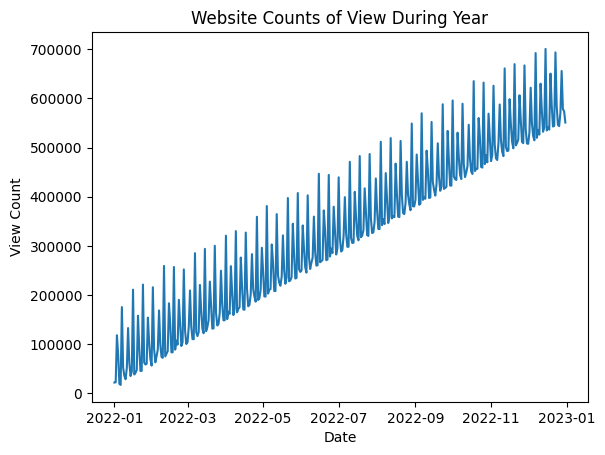

In [13]:
resampled_data = datapoints.resample('D', on='time_index').sum()
plt.plot(resampled_data.index, resampled_data['view_count'])
plt.xlabel('Date')
plt.ylabel('View Count')
plt.title('Website Counts of View During Year')
plt.show()

In [14]:
#Seasonality Analysis
decomposition = seasonal_decompose(resampled_data['view_count'], model='additive')

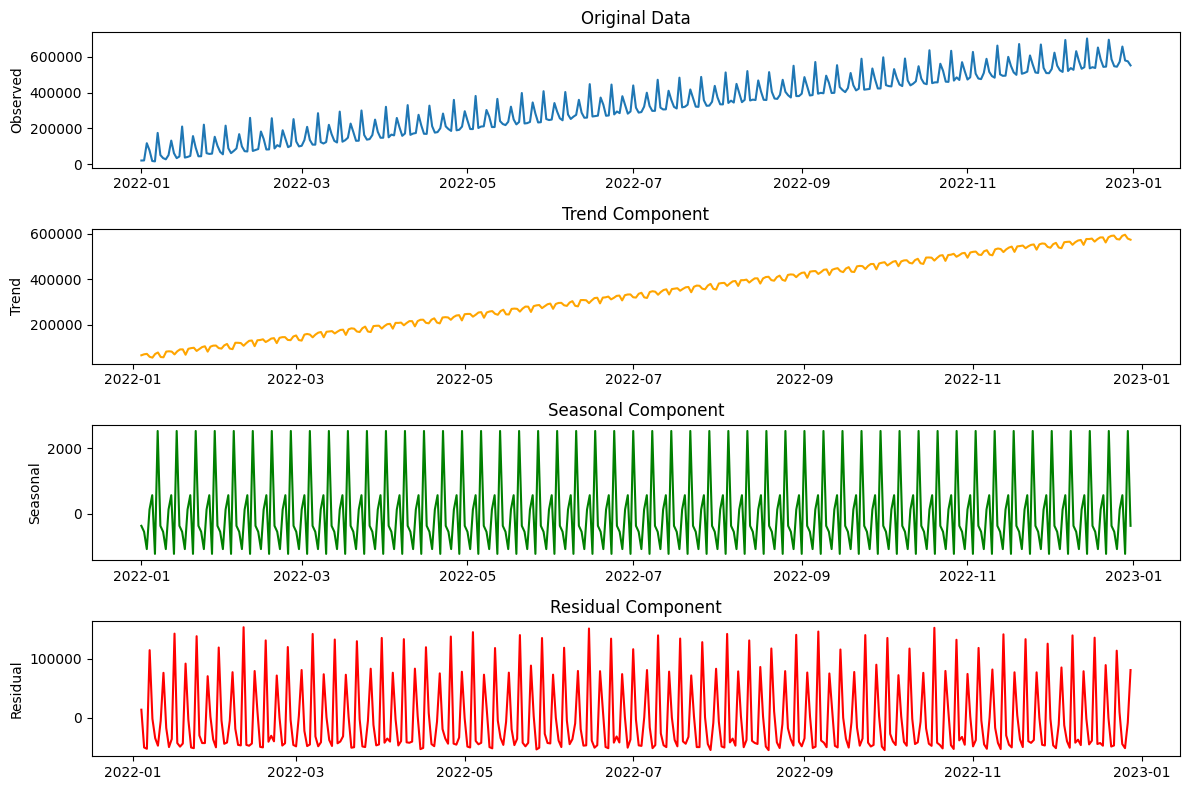

In [15]:
# Visualize the seasonal decomposition components
plt.figure(figsize=(12, 8))

# Original Data
plt.subplot(4, 1, 1)
plt.plot(resampled_data.index, decomposition.observed)
plt.ylabel('Observed')
plt.title('Original Data')

# Trend Component
plt.subplot(4, 1, 2)
plt.plot(resampled_data.index, decomposition.trend, color='orange')
plt.ylabel('Trend')
plt.title('Trend Component')

# Seasonal Component
plt.subplot(4, 1, 3)
plt.plot(resampled_data.index, decomposition.seasonal, color='green')
plt.ylabel('Seasonal')
plt.title('Seasonal Component')

# Residual Component
plt.subplot(4, 1, 4)
plt.plot(resampled_data.index, decomposition.resid, color='red')
plt.ylabel('Residual')
plt.title('Residual Component')

plt.tight_layout()
plt.savefig('Seasonality.png')
plt.show()

We can observe seasonality in this data. Original data has steady trend

#Paterns on weekends

Identify which of the segments tend to have the most similar view patterns on
weekends. Please split it by Desktop/Mobile users and visualize it. Are the similarities
intuitive or counter-intuitive? Provide arguments for your opinion.

In [16]:
#Set string array with unique "segmanet_name" names
unique_segments = datapoints['segment_name'].unique()

#Create empty dataframe for storing merged data
weekend_data = pd.DataFrame()

for i in unique_segments:
    segment_data = datapoints[datapoints['segment_name'] == i]

    merged_data = segment_data.resample('D', on='time_index').sum()
    merged_data = merged_data[merged_data.index.dayofweek.isin([5, 6])]

    merged_data['segment_name'] = i

    weekend_data = pd.concat([weekend_data, merged_data])

#Shift column 'segment_name' to first position and drop unessesery columns
first_column = weekend_data.pop('segment_name')
weekend_data.insert(0, 'segment_name', first_column)
weekend_data = weekend_data.reset_index()
weekend_data = weekend_data.drop(['view_count', 'windows', 'android', 'mac os x', 'iphone', 'other'], axis = 1)

<ipython-input-16-3fa4038d9a6c>:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged_data = segment_data.resample('D', on='time_index').sum()
<ipython-input-16-3fa4038d9a6c>:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged_data = segment_data.resample('D', on='time_index').sum()
<ipython-input-16-3fa4038d9a6c>:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged_data = segment_data.resample('D', on='time_

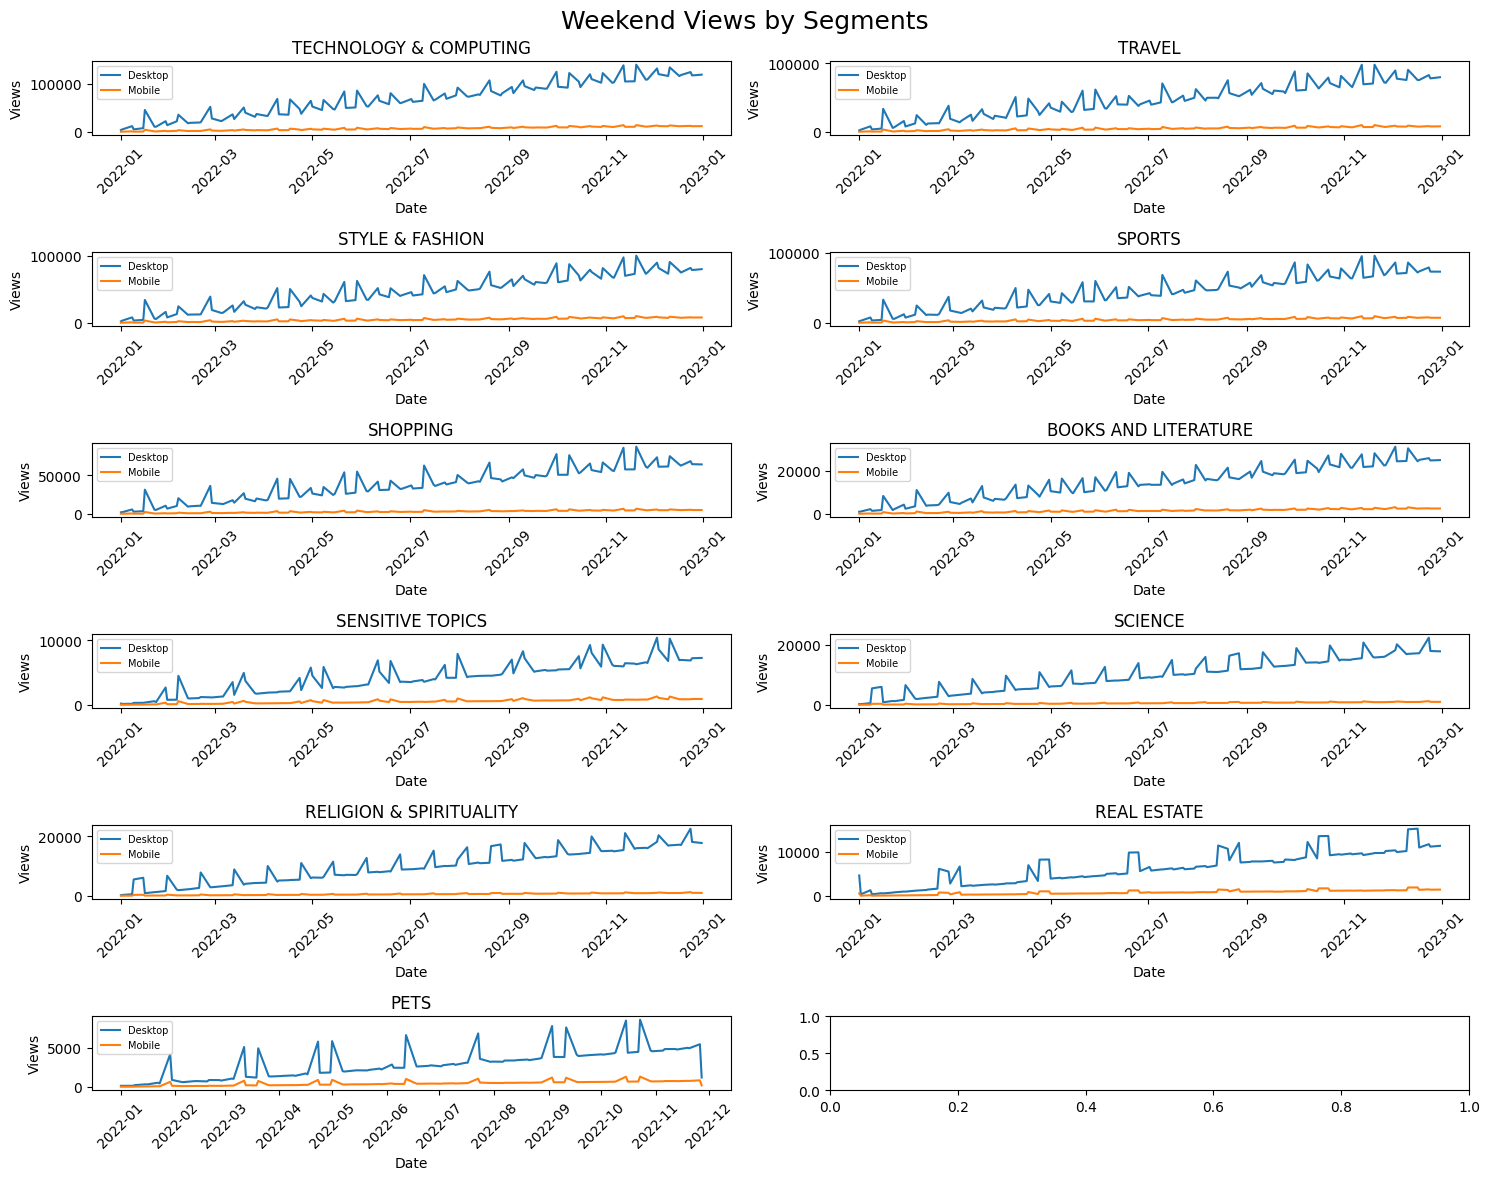

In [17]:
#Define subplot grid
fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Weekend Views by Segments", fontsize=18, y=0.98)

#Loop through unique segment names and axes
for segment_name, ax in zip(unique_segments, axs.ravel()):
    # Filter the data for the current segment
    segment_data = weekend_data[weekend_data["segment_name"] == segment_name]

    #Plot the filtered data on the current subplot
    ax.plot(segment_data["time_index"], segment_data["desktop"], label = 'Desktop')
    ax.plot(segment_data["time_index"], segment_data["mobile"], label = 'Mobile')

    #Chart formatting
    ax.set_title(segment_name.upper())
    ax.set_xlabel("Date")
    ax.set_ylabel("Views")
    ax.xaxis.set_tick_params(rotation = 45)
    ax.legend(fontsize="7", loc ="upper left")

plt.tight_layout()
plt.savefig("Paterns_on_weekends.png")
plt.show()


In [18]:
#Calculate correlation for each segment
correlation_results = {}

for segment in unique_segments:
    segment_data = weekend_data[weekend_data['segment_name'] == segment]
    correlation = segment_data['desktop'].corr(segment_data['mobile'])
    correlation_results[segment] = correlation

#Display correlation results
for segment, correlation in correlation_results.items():
    print(f"Correlation for {segment}: {correlation:.2f}")

Correlation for Technology & Computing: 1.00
Correlation for Travel: 1.00
Correlation for Style & Fashion: 1.00
Correlation for Sports: 1.00
Correlation for Shopping: 1.00
Correlation for Books and Literature: 1.00
Correlation for Sensitive Topics: 1.00
Correlation for Science: 1.00
Correlation for Religion & Spirituality: 1.00
Correlation for Real Estate: 1.00
Correlation for Pets: 1.00


<ipython-input-30-65913a868661>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  weekend_averages = weekend_data.groupby('segment_name')['desktop', 'mobile'].mean()
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


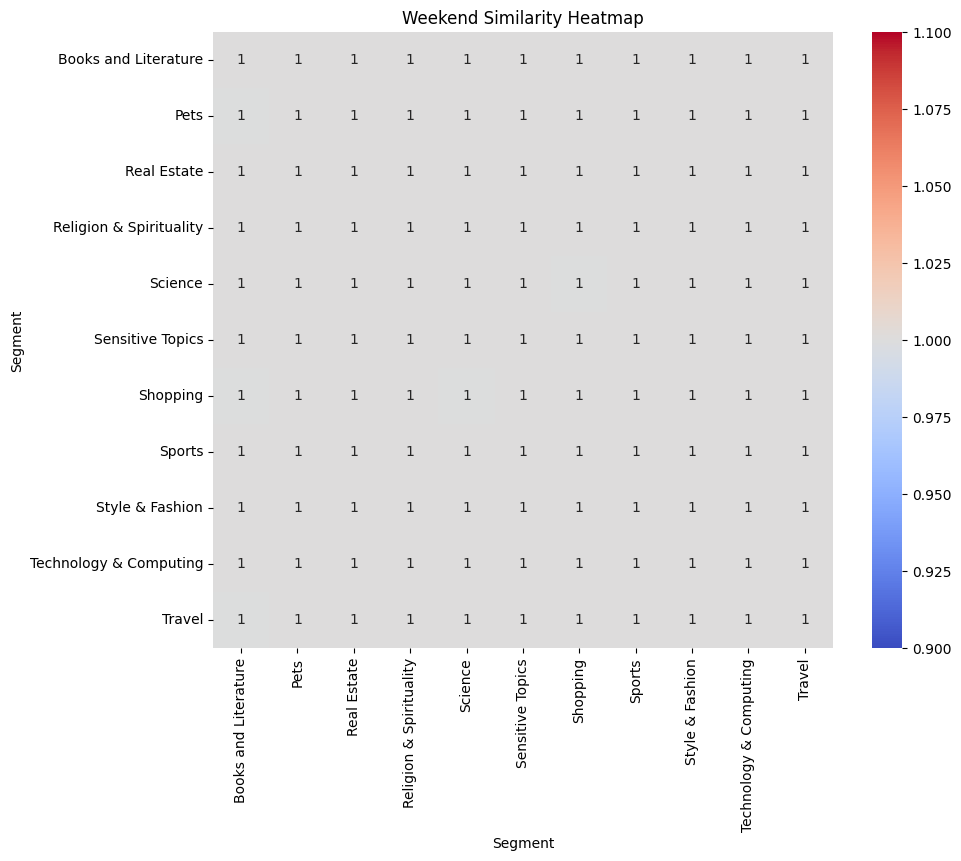

In [30]:
#Weekend Similarity Analysis
weekend_averages = weekend_data.groupby('segment_name')['desktop', 'mobile'].mean()
correlation_matrix = np.corrcoef(weekend_averages.values)
k = 11
kmeans = KMeans(n_clusters=k)
clusters = kmeans.fit_predict(correlation_matrix)

#Plot the correlation matrix on the current subplot
plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', xticklabels=weekend_averages.index, yticklabels=weekend_averages.index)

plt.title('Weekend Similarity Heatmap')
plt.xlabel('Segment')
plt.ylabel('Segment')

plt.savefig("Weekend Similarity Heatmap.png")
plt.show()

In [20]:
#Calculate Pearson correlation between Desktop and Mobile
corr, _ = pearsonr(weekend_data['desktop'], weekend_data['mobile'])
print(f"Pearson Correlation between Desktop and Mobile: {corr:.3f}")

Pearson Correlation between Desktop and Mobile: 0.991


In [21]:
#Finds out the Prices data for each FuelType as a list
CategoryGroupListsDesktop = weekend_data.groupby('segment_name')['desktop'].apply(list)
CategoryGroupListsMobile = weekend_data.groupby('segment_name')['mobile'].apply(list)

#Performing the ANOVA test
#We accept the Assumption(HO) only when P-Value < 0.05
AnovaResultsDektop = f_oneway(*CategoryGroupListsDesktop)
AnovaResultsMobile = f_oneway(*CategoryGroupListsMobile)

print('P-Value for Desktop for Anova is: ', AnovaResultsDektop[1])
print('P-Value for Mobile For Anova is: ', AnovaResultsMobile[1])

P-Value for Desktop for Anova is:  3.904275146279603e-210
P-Value for Mobile For Anova is:  5.869694431628765e-220


 We can see the Pearson correlation coefficient is currently at 0.991, which is signaling a strong positive correlation.

 P-Value means that the result is statistically significant

#December Prediction


In [22]:
#Train size param
train_size = 0.8

#Create empty dataframe for storing merged data
datapoints_daily = pd.DataFrame()

#Create daily resoults for each segment
for segment in unique_segments:
    segment_data = datapoints[datapoints['segment_name'] == segment]

    merged_data = segment_data.resample('D', on='time_index').sum()
    merged_data['segment_name'] = segment

    datapoints_daily = pd.concat([datapoints_daily, merged_data])

#Shift column 'segment_name' to first position
first_column = datapoints_daily.pop('segment_name')
datapoints_daily.insert(0, 'segment_name', first_column)
datapoints_daily = datapoints_daily.reset_index()

<ipython-input-22-b1926d45f687>:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged_data = segment_data.resample('D', on='time_index').sum()
<ipython-input-22-b1926d45f687>:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged_data = segment_data.resample('D', on='time_index').sum()
<ipython-input-22-b1926d45f687>:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged_data = segment_data.resample('D', on='time_

In [31]:
#Create function that shows metrics
def calculate_metrics_for_model(y_test, predictions):
  metrics_dict = {"MAPE": np.round(mean_absolute_percentage_error(y_test,predictions), 2),
                  "MAE": np.round(mean_absolute_error(y_test,predictions), 2),
                  "MSE": np.round(mean_squared_error(y_test,predictions), 2),
                  "RMSE": np.round(np.sqrt(mean_squared_error(y_test,predictions)),2)}
  return metrics_dict

##ARIMA

In [ ]:
#Create ARIMA model for getting best params
#Define ranges for parameter values
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)

best_score_arima = float('inf')
best_params_arima = None

segment_data = datapoints_daily[datapoints_daily['segment_name'] == 'Travel']
segment_data_array = segment_data[['view_count']].values
train_data_size = math.ceil(len(segment_data) * train_size)

#Create train dataset
train_data = segment_data_array[:train_data_size, :]

#Loop through parameter combinations
for p, d, q in itertools.product(p_values, d_values, q_values):
    try:
        model = SARIMAX(train_data, order=(p, d, q))
        results = model.fit()

        #Generate forecasts on validation set
        forecast = results.get_forecast(steps=len(segment_data_array))
        forecasted_values = forecast.predicted_mean

        #Calculate evaluation metric (RMSE)
        rmse = mean_squared_error(segment_data_array, forecasted_values, squared=False)

        if rmse < best_score_arima:
            best_score_arima = rmse
            best_params_arima = (p, d, q)

    except:
        continue

print(f"Best ARIMA parameters: {best_params_arima}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


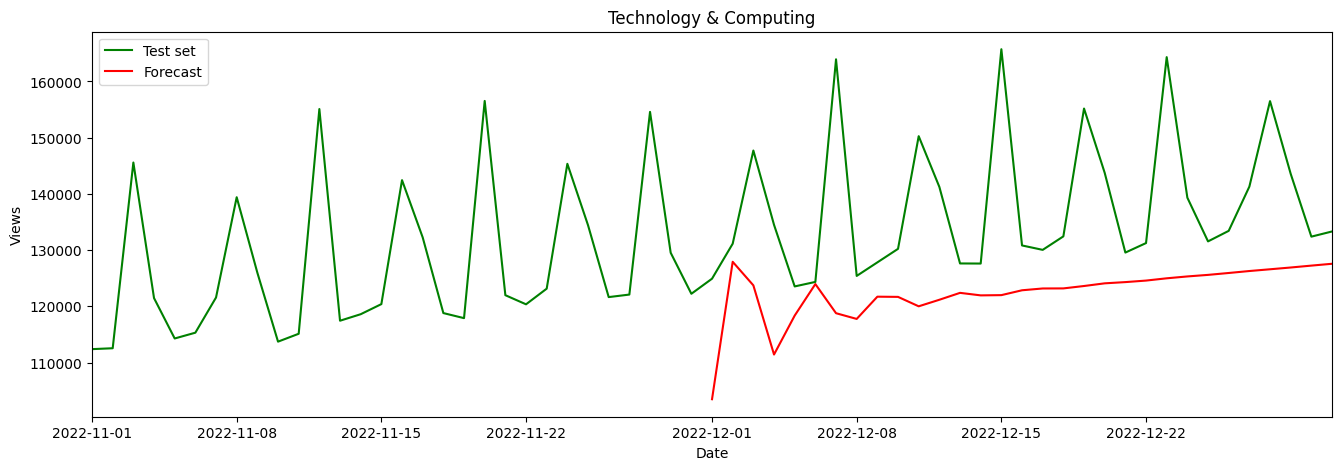

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


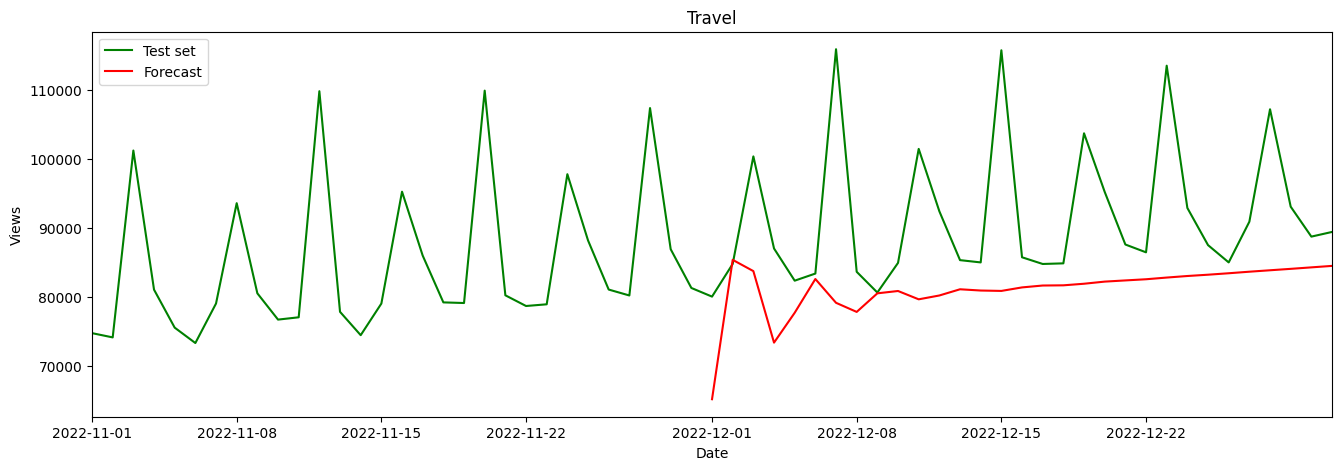

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


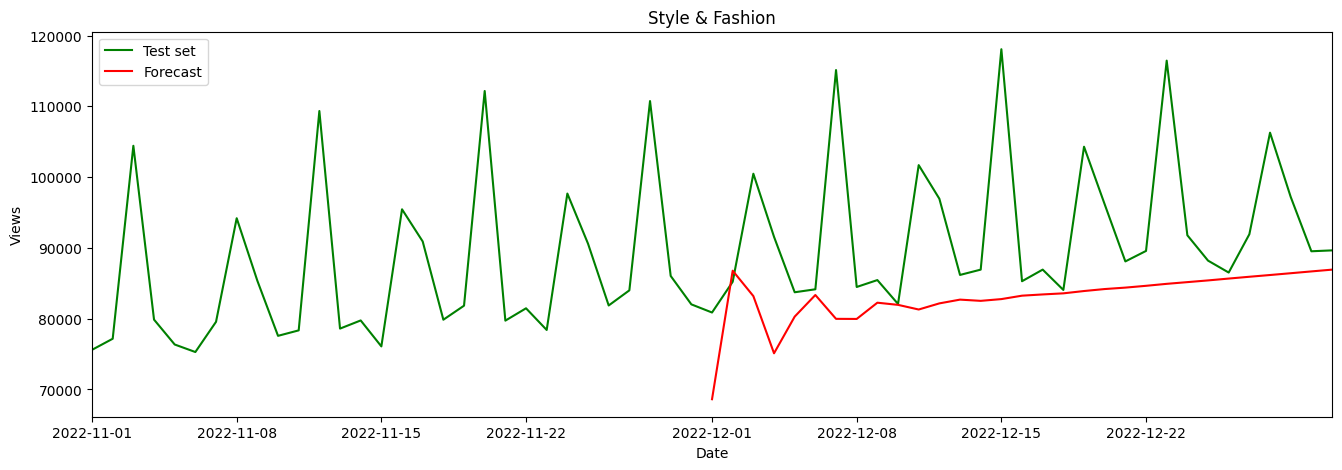

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


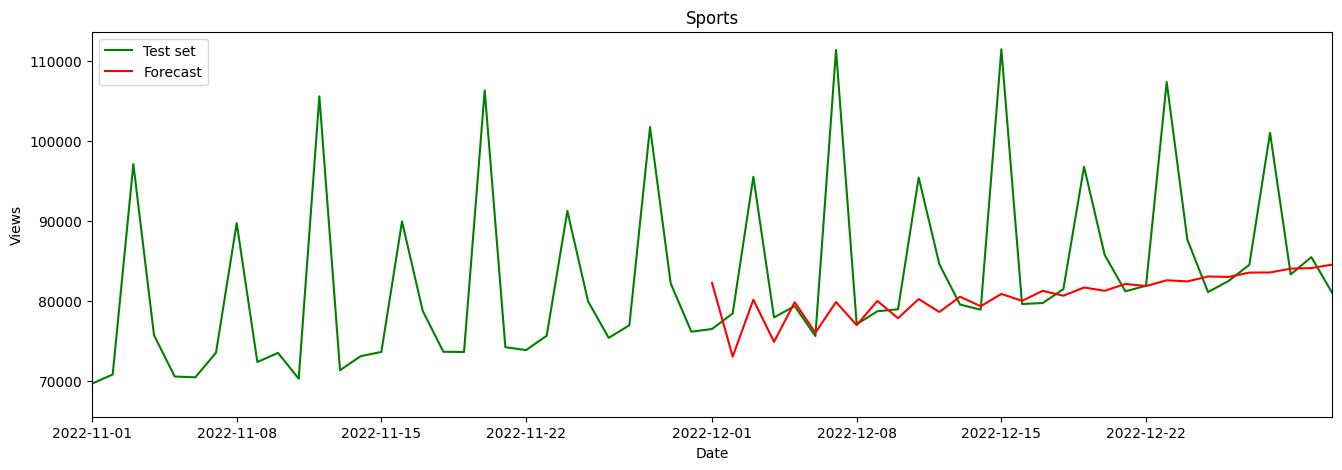

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


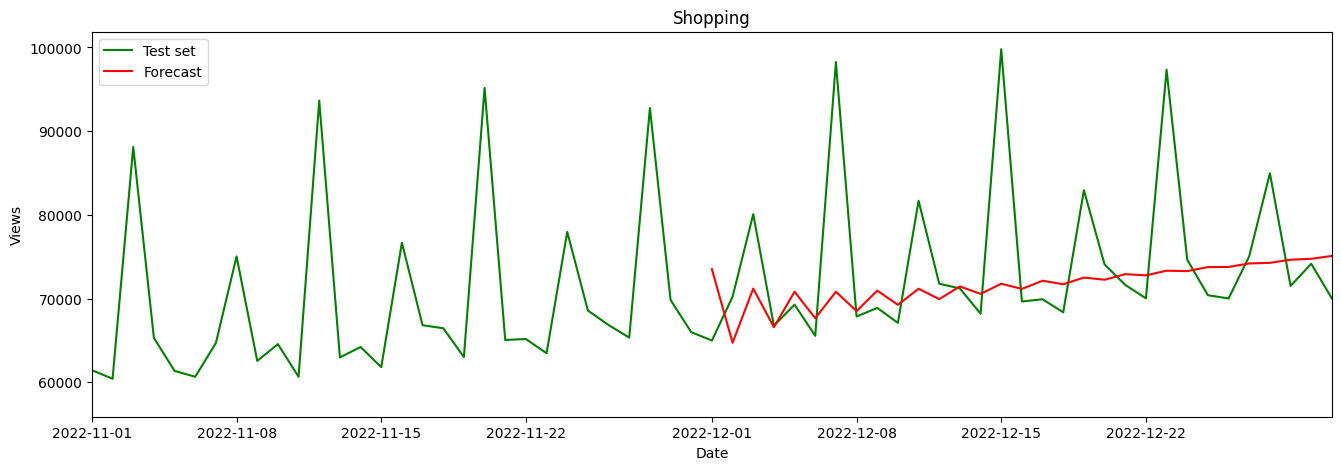

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


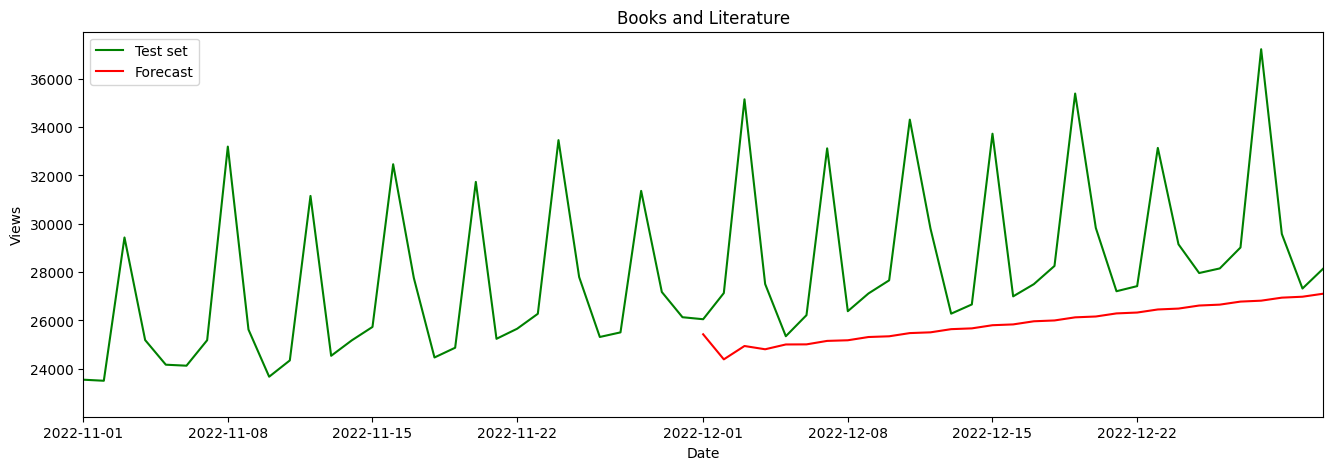

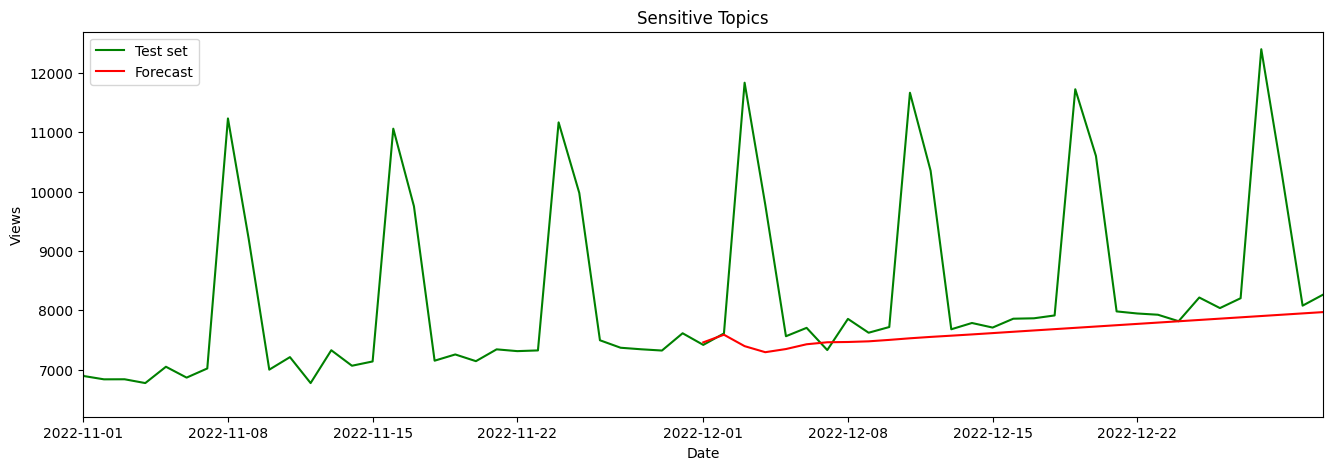

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


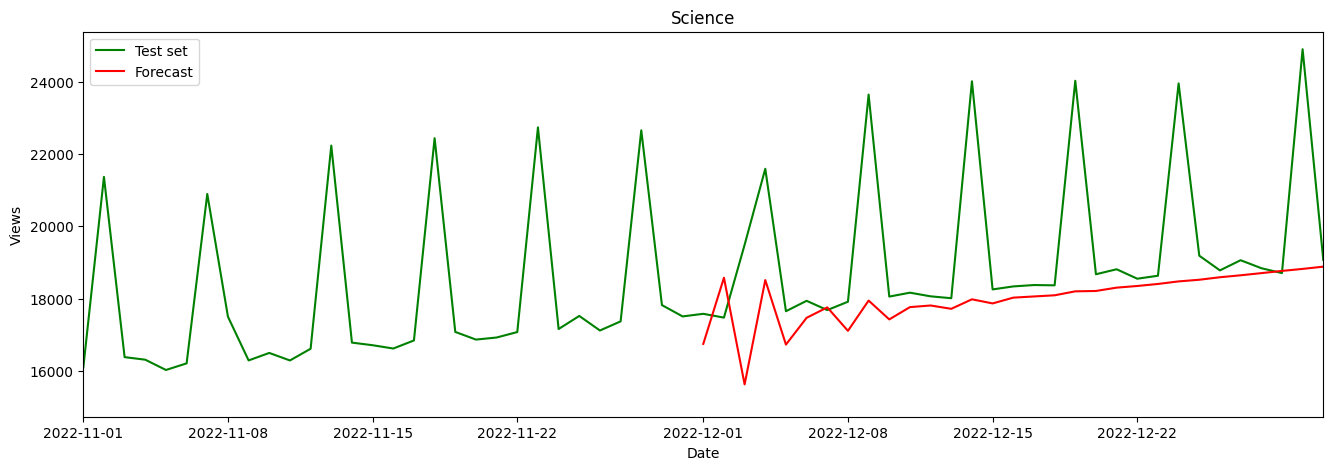

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


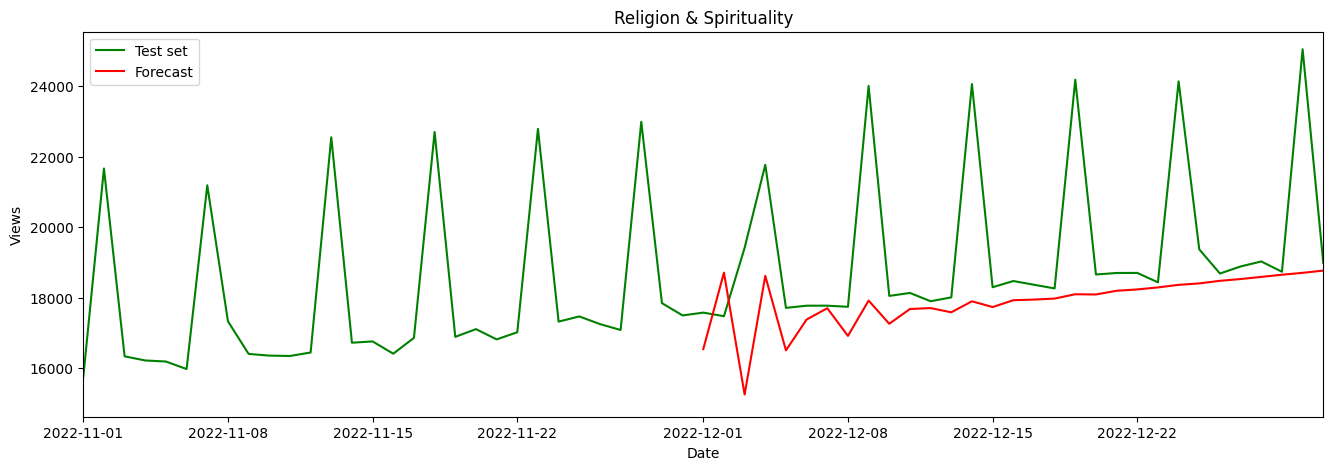

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


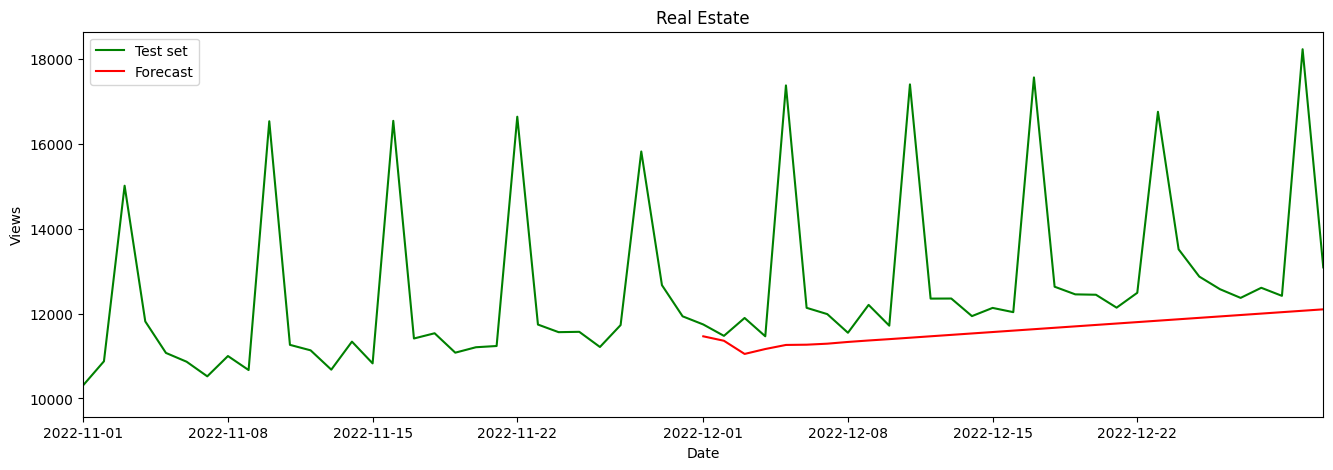

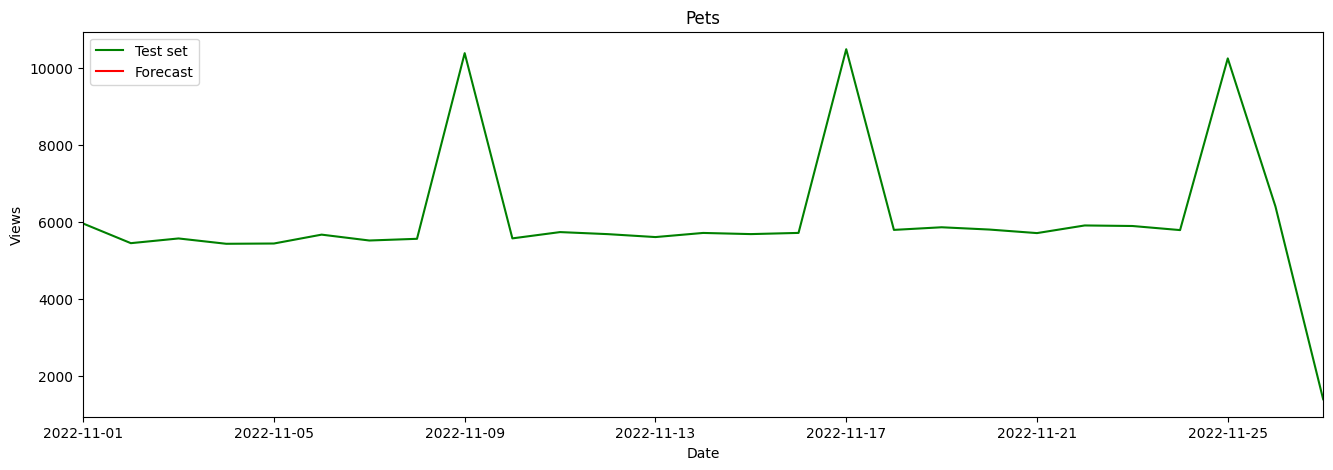

In [26]:
#ARIMA params
#order = (best_params_arima[0],best_params_arima[1],best_params_arima[2])\
order = (2, 2, 2)

#Filter data up to November 27, 2022
end_date = datetime(2022, 11, 27)
datapoints_daily_filtered = datapoints_daily[datapoints_daily['time_index'] <= end_date]

#Fit and forecast for each device
for segment in unique_segments:
    segment_data = datapoints_daily[datapoints_daily['segment_name'] == segment]
    segment_data_array = segment_data[['view_count']].values
    train_data_size = math.ceil(len(segment_data) * train_size)

    #Create train dataset
    train_data = segment_data_array[:train_data_size, :]

    model = ARIMA(train_data, order=order)
    results = model.fit()

    #Forecast view counts for December 2022
    forecast_start_date = datetime(2022, 12, 1)
    forecast_end_date = datetime(2022, 12, 31)
    forecast_dates = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq='D')
    forecast_steps = len(forecast_dates)
    forecast = results.get_forecast(steps=forecast_steps).predicted_mean

    forecast_aligned = pd.Series(forecast, index=forecast_dates)

    plt.figure(figsize=(16, 5))

    #Plot test values
    plt.plot(segment_data.time_index.values[train_data_size:], segment_data_array[train_data_size:],
            label='Test set', color='green')
    #Plot predictions
    plt.plot(forecast_aligned.index, forecast_aligned.values,
            label='Forecast', color='red')

    plt.xlim([datetime(2022, 11, 1), segment_data.time_index.values[-1]])
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('Views')
    plt.title(f'{segment}')
    plt.savefig(f"ARIMA_{segment}.png")

    plt.show()

##SARIMA

In [ ]:
#Create SARIMA model for getting best params
#Define ranges for parameter values
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)
P_values = range(0, 2)
D_values = range(0, 2)
Q_values = range(0, 2)
s_values = [7]  # Weekly seasonality

best_score_sarima = float('inf')
best_params_sarima = None

segment_data = datapoints_daily[datapoints_daily['segment_name'] == 'Travel']
segment_data_array = segment_data[['view_count']].values
train_data_size = math.ceil(len(segment_data) * train_size)

#Create train dataset
train_data = segment_data_array[:train_data_size, :]

#Loop through parameter combinations
for p, d, q, P, D, Q, s in itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values):
    try:
        model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, s))
        results = model.fit()

        #Generate forecasts on validation set
        forecast = results.get_forecast(steps=len(segment_data_array))
        forecasted_values = forecast.predicted_mean

        #Calculate evaluation metric (RMSE)
        rmse = mean_squared_error(segment_data_array, forecasted_values, squared=False)

        if rmse < best_score_sarima:
            best_score_sarima = rmse
            best_params_sarima = (p, d, q, P, D, Q, s)

    except:
        continue

print(f"Best SARIMA parameters: {best_params_sarima}")


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


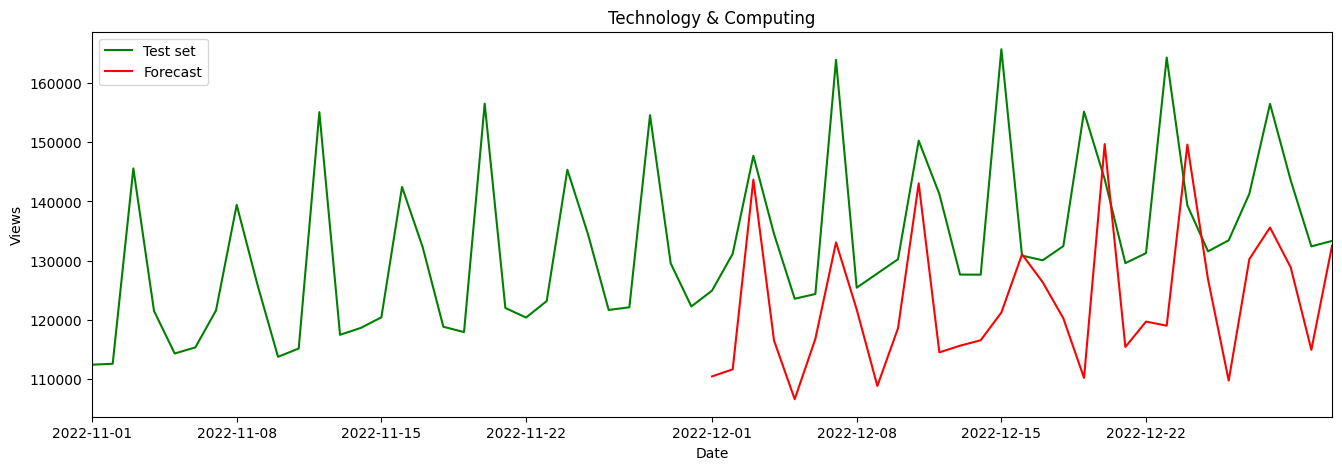

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


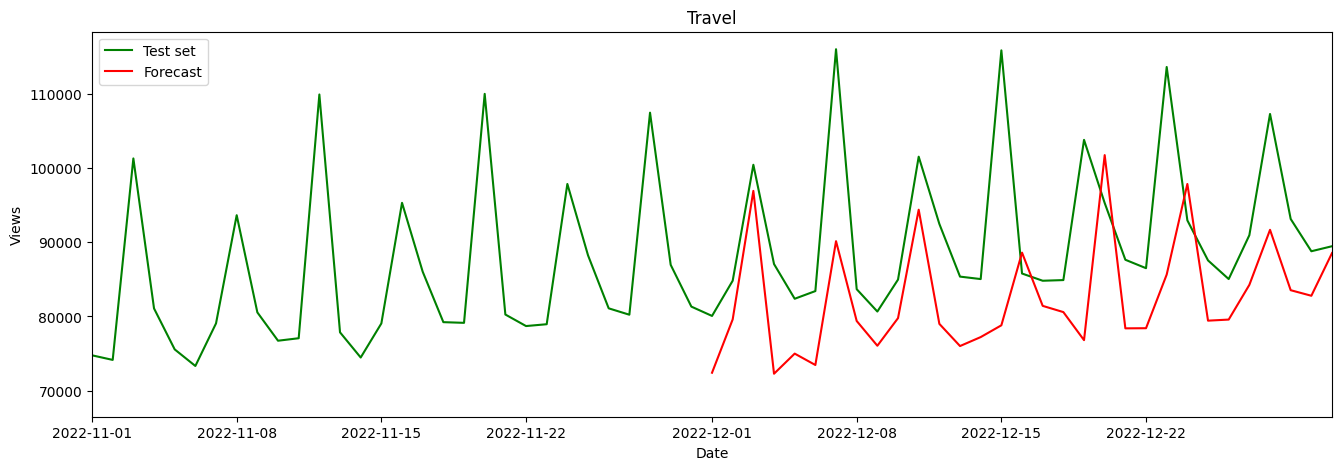

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


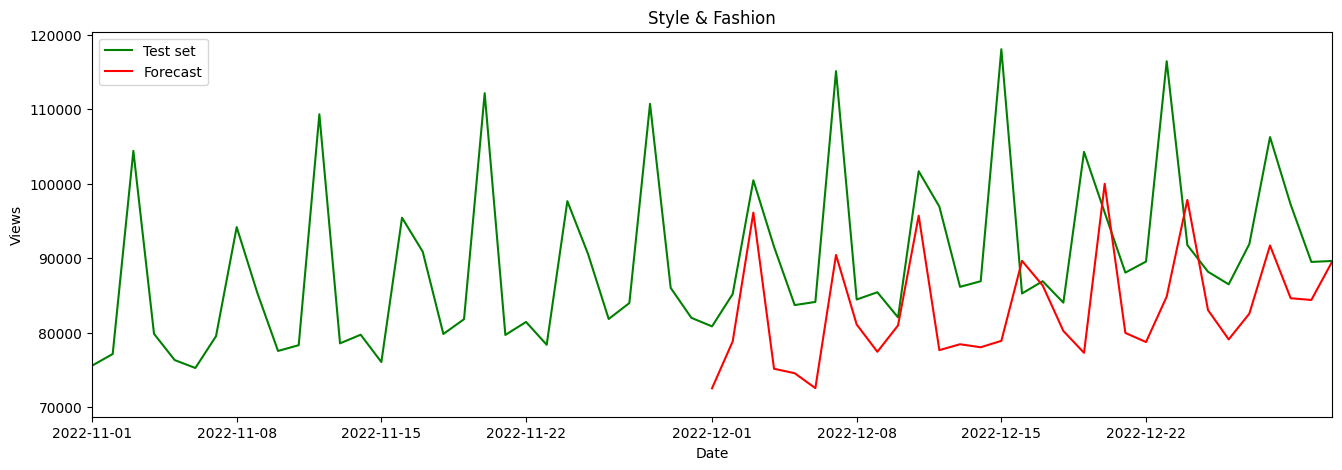

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


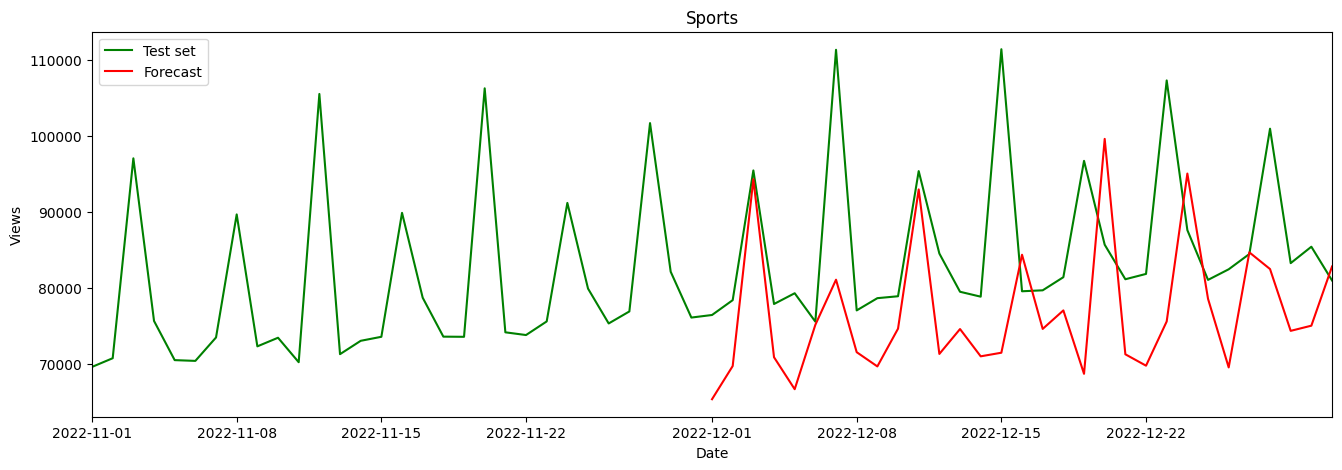

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


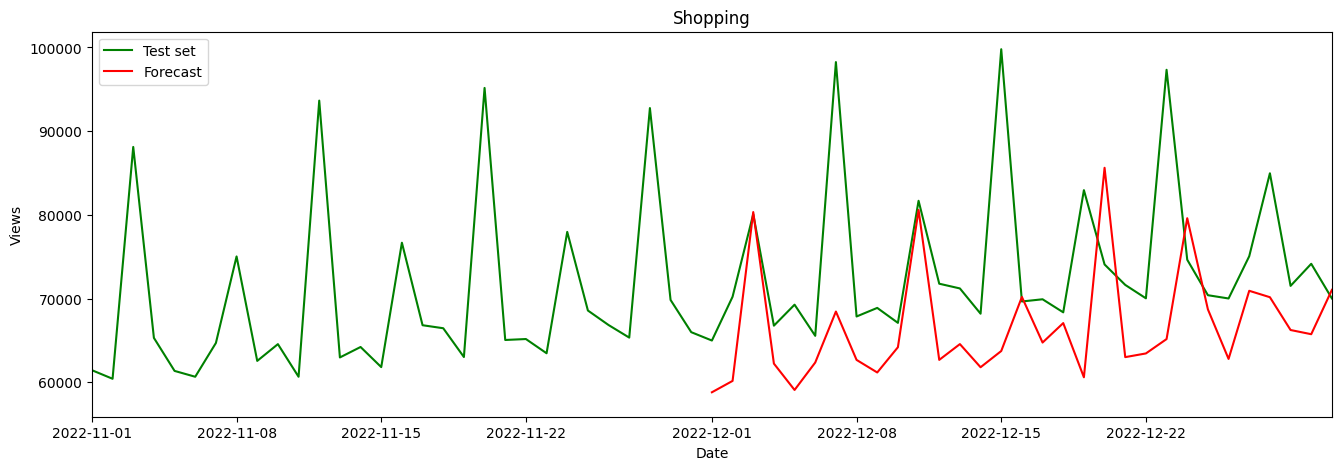

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


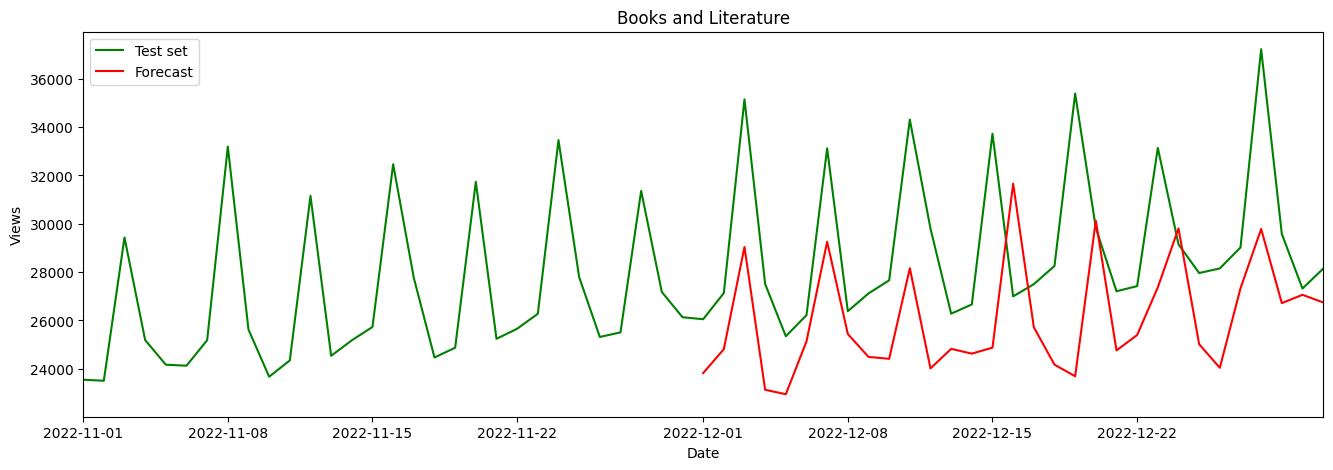

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


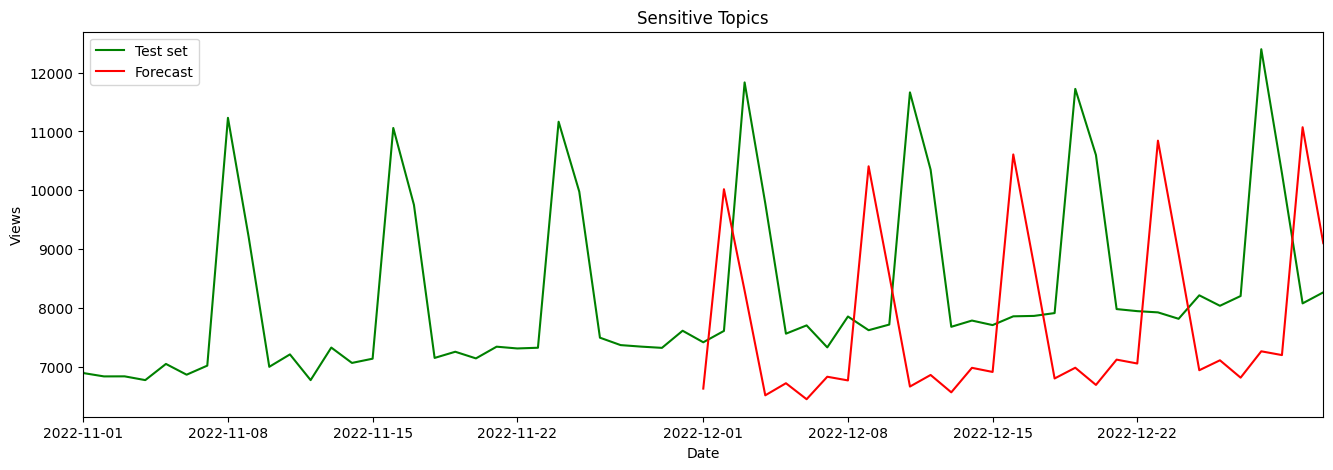

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


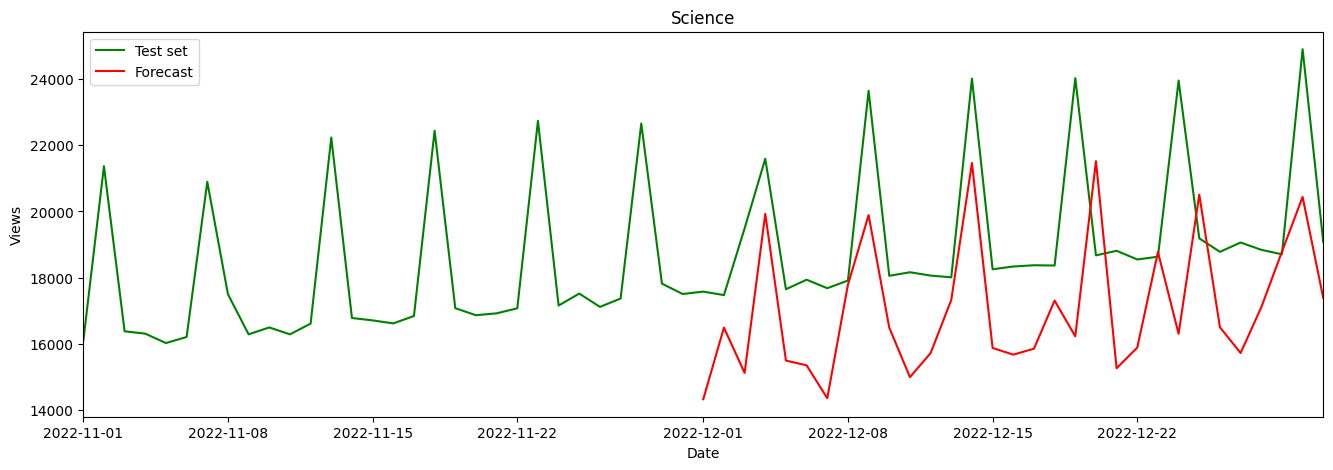

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


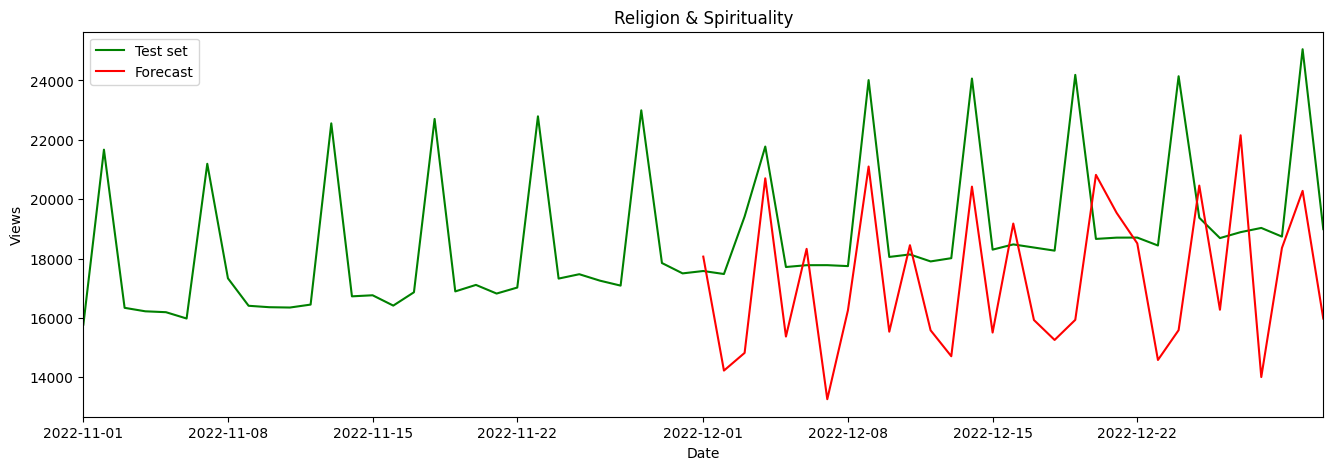

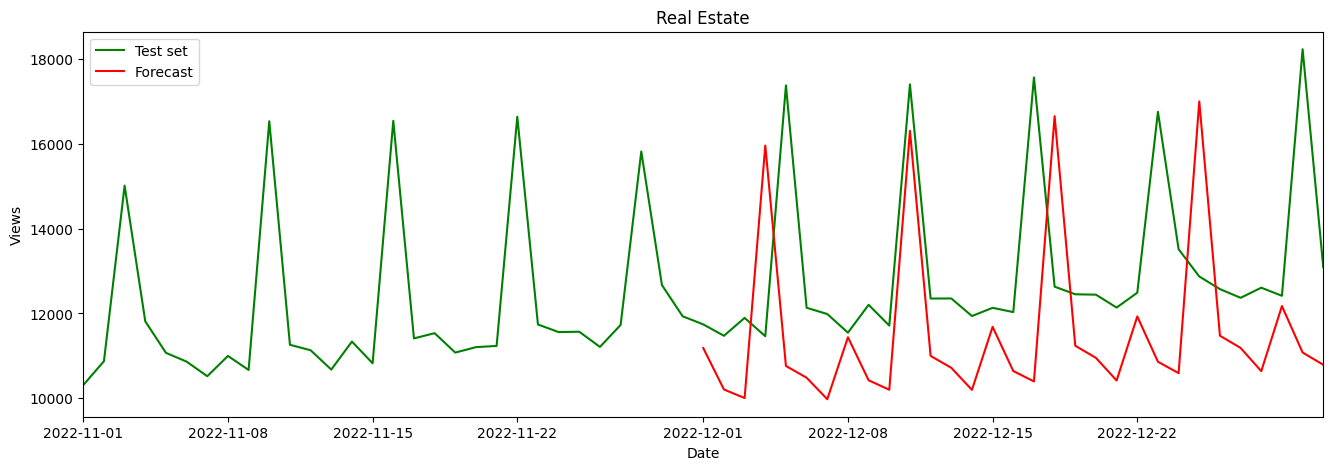

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


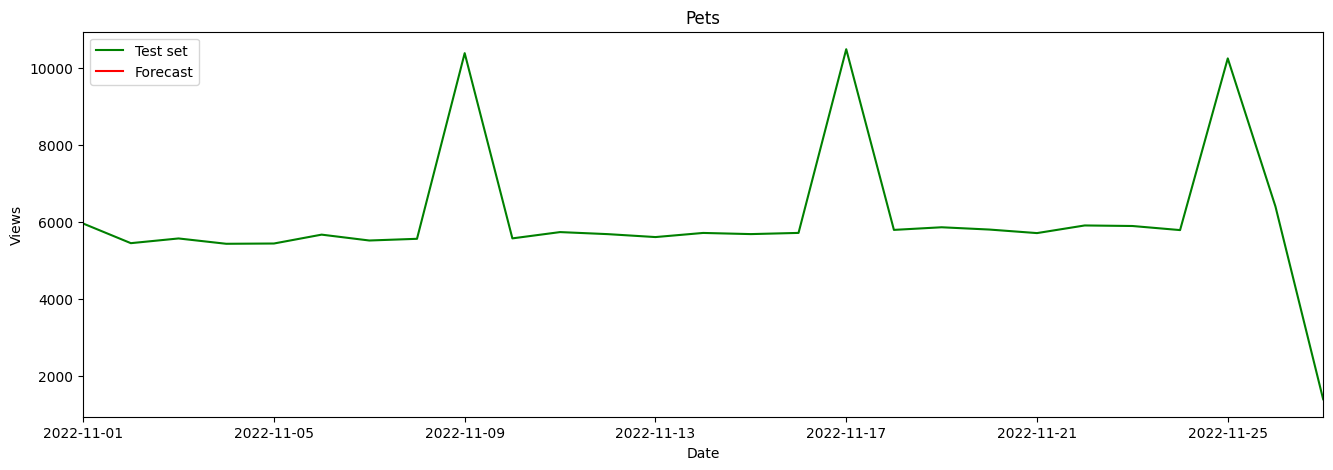

In [27]:
#SARIMA params
#order = (best_params_sarima[0],best_params_sarima[1],best_params_sarima[2])
#seasonal_order = (best_params_sarima[3],best_params_sarima[4],best_params_sarima[5], 7)
order = (1, 0, 1)
seasonal_order = (2, 2, 2, 7)
# Filter data up to November 27, 2022
end_date = datetime(2022, 11, 27)
datapoints_daily_filtered = datapoints_daily[datapoints_daily['time_index'] <= end_date]


# Fit and forecast for each device
for segment in unique_segments:
    segment_data = datapoints_daily[datapoints_daily['segment_name'] == segment]
    segment_data_array = segment_data[['view_count']].values
    train_data_size = math.ceil(len(segment_data) * train_size)

    #Create train dataset
    train_data = segment_data_array[:train_data_size, :]


    model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
    results = model.fit()

    #Forecast view counts for December 2022
    forecast_start_date = datetime(2022, 12, 1)
    forecast_end_date = datetime(2022, 12, 31)
    forecast_dates = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq='D')
    forecast_steps = len(forecast_dates)
    forecast = results.get_forecast(steps=forecast_steps).predicted_mean

    forecast_aligned = pd.Series(forecast, index=forecast_dates)

    plt.figure(figsize=(16, 5))

    #Plot test values
    plt.plot(segment_data.time_index.values[train_data_size:], segment_data_array[train_data_size:],
            label='Test set', color='green')
    #Plot predictions
    plt.plot(forecast_aligned.index, forecast_aligned.values,
            label='Forecast', color='red')

    plt.xlim([datetime(2022, 11, 1), segment_data.time_index.values[-1]])
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('Views')
    plt.title(f'{segment}')
    plt.savefig(f"SARIMA_{segment}.png")

    plt.show()

##LSTM

In [ ]:
#Create LSTM model for getting best params
#Define parameter ranges
lstm_units = [40, 50, 60, 80, 100]
epochs = [10, 15, 20, 30]
batch_sizes = [1, 16, 32, 64, 128]
learning_rates = [0.001, 0.01, 0.1]

best_score = float('inf')
best_params = None

segment_data = datapoints_daily[datapoints_daily['segment_name'] == 'Travel']
segment_data_array = segment_data[['view_count']].values
train_data_size = math.ceil(len(segment_data) * train_size)

#Scale
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data_array = scaler.fit_transform(segment_data_array)

#Create train dataset
train_data = scaled_data_array[:train_data_size, :]

X_train, y_train = [], []
for i in range(60, len(train_data)):
      X_train.append(train_data[i-60:i, 0])
      y_train.append(train_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

#Create test dataset
test_data_scaled = scaled_data_array[train_data_size-60:, :]
test_data = segment_data_array[train_data_size-60:, :]

#X and y data splitting:
X_test, y_test = [], []

for i in range(60, len(test_data_scaled)):
    X_test.append(test_data_scaled[i-60:i, 0])
    y_test.append(test_data[i, 0])

#Convert X_test and y_test to Numpy Array
X_test, y_test = np.array(X_test), np.array(y_test)

#Data dimension transformation
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

for units in lstm_units:
    for num_epochs in epochs:
        for batch_size in batch_sizes:
            for lr in learning_rates:
                model = Sequential([
                    LSTM(units, input_shape=(X_train.shape[1], X_train.shape[2])),
                    Dense(1)
                ])
                optimizer = Adam(learning_rate=lr)
                model.compile(optimizer=optimizer, loss='mean_squared_error')
                model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, verbose=0)

                #Predict on test set
                y_pred = model.predict(X_test)

                #Calculate evaluation metric (e.g., RMSE)
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))

                if rmse < best_score:
                    best_score = rmse
                    best_params = (units, num_epochs, batch_size, lr)

print(f"Best LSTM parameters: {best_params}")


Epoch 1/20
232/232 [==============================] - 20s 61ms/step - loss: 0.0136 - mse: 0.0136 - mae: 0.0936 - mape: 23.8051
Epoch 2/20
232/232 [==============================] - 8s 35ms/step - loss: 0.0092 - mse: 0.0092 - mae: 0.0759 - mape: 18.2839
Epoch 3/20
232/232 [==============================] - 7s 31ms/step - loss: 0.0087 - mse: 0.0087 - mae: 0.0762 - mape: 18.8071
Epoch 4/20
232/232 [==============================] - 8s 35ms/step - loss: 0.0082 - mse: 0.0082 - mae: 0.0728 - mape: 17.7527
Epoch 5/20
232/232 [==============================] - 8s 36ms/step - loss: 0.0089 - mse: 0.0089 - mae: 0.0754 - mape: 18.4183
Epoch 6/20
232/232 [==============================] - 7s 29ms/step - loss: 0.0076 - mse: 0.0076 - mae: 0.0702 - mape: 17.3086
Epoch 7/20
232/232 [==============================] - 8s 34ms/step - loss: 0.0074 - mse: 0.0074 - mae: 0.0684 - mape: 16.7704
Epoch 8/20
232/232 [==============================] - 7s 30ms/step - loss: 0.0057 - mse: 0.0057 - mae: 0.0605 - mape:

3/3 [==============================] - 1s 19ms/step
{'MAPE': 0.06, 'MAE': 7891.14, 'MSE': 96919698.11, 'RMSE': 9844.78}


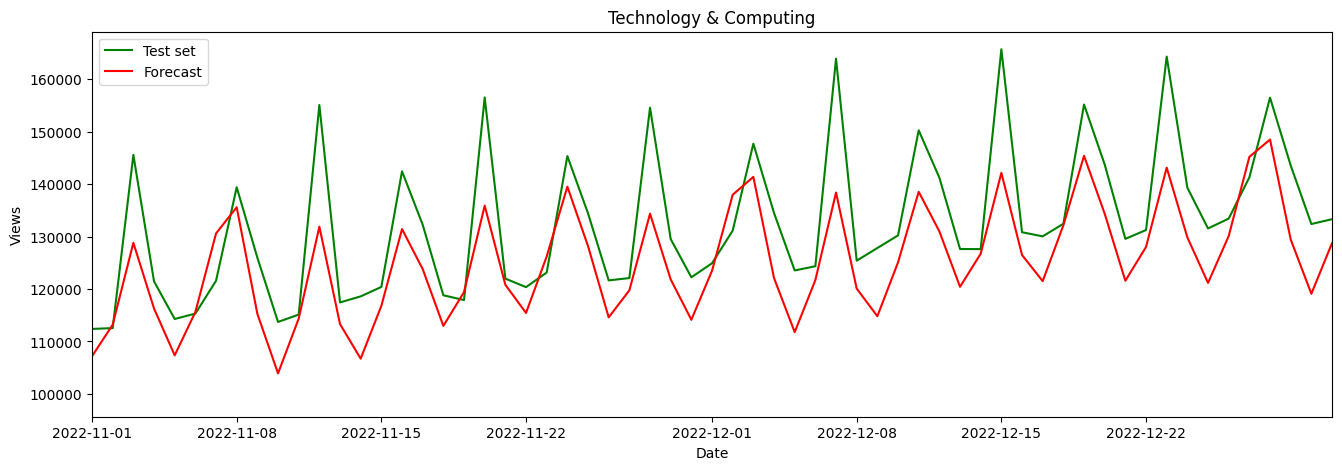

Epoch 1/20
232/232 [==============================] - 14s 34ms/step - loss: 0.0145 - mse: 0.0145 - mae: 0.0974 - mape: 25.8771
Epoch 2/20
232/232 [==============================] - 9s 38ms/step - loss: 0.0130 - mse: 0.0130 - mae: 0.0887 - mape: 23.1946
Epoch 3/20
232/232 [==============================] - 8s 36ms/step - loss: 0.0106 - mse: 0.0106 - mae: 0.0812 - mape: 21.1179
Epoch 4/20
232/232 [==============================] - 9s 40ms/step - loss: 0.0110 - mse: 0.0110 - mae: 0.0827 - mape: 21.5602
Epoch 5/20
232/232 [==============================] - 8s 36ms/step - loss: 0.0103 - mse: 0.0103 - mae: 0.0789 - mape: 20.2748
Epoch 6/20
232/232 [==============================] - 8s 33ms/step - loss: 0.0085 - mse: 0.0085 - mae: 0.0722 - mape: 18.7872
Epoch 7/20
232/232 [==============================] - 9s 38ms/step - loss: 0.0072 - mse: 0.0072 - mae: 0.0656 - mape: 16.9994
Epoch 8/20
232/232 [==============================] - 8s 37ms/step - loss: 0.0075 - mse: 0.0075 - mae: 0.0673 - mape:

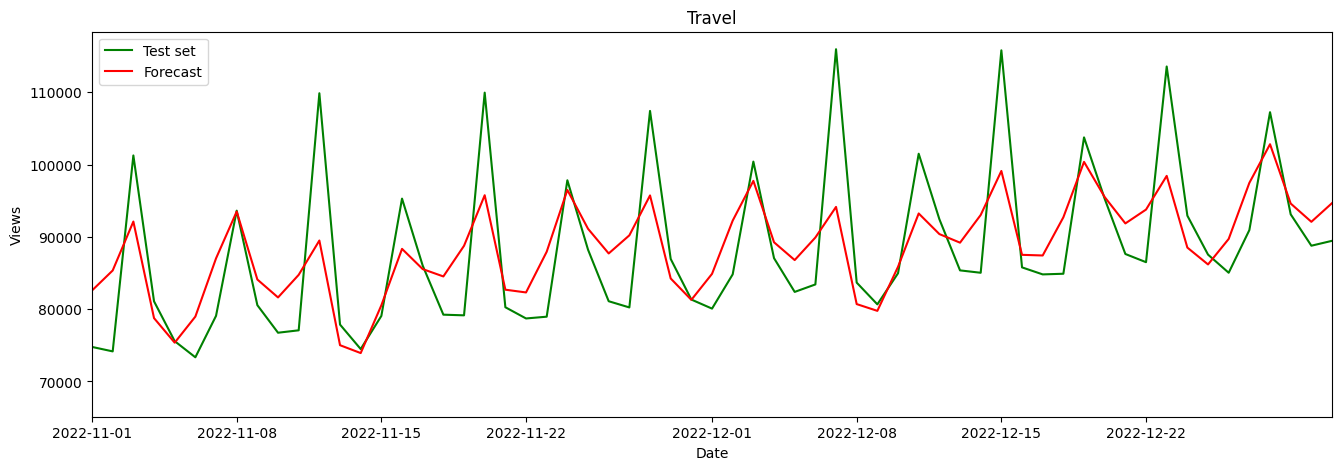

Epoch 1/20
232/232 [==============================] - 12s 31ms/step - loss: 0.0164 - mse: 0.0164 - mae: 0.0932 - mape: 24.6112
Epoch 2/20
232/232 [==============================] - 9s 37ms/step - loss: 0.0103 - mse: 0.0103 - mae: 0.0804 - mape: 20.9846
Epoch 3/20
232/232 [==============================] - 8s 36ms/step - loss: 0.0110 - mse: 0.0110 - mae: 0.0818 - mape: 20.8842
Epoch 4/20
232/232 [==============================] - 8s 32ms/step - loss: 0.0097 - mse: 0.0097 - mae: 0.0751 - mape: 19.5938
Epoch 5/20
232/232 [==============================] - 8s 36ms/step - loss: 0.0103 - mse: 0.0103 - mae: 0.0760 - mape: 19.6379
Epoch 6/20
232/232 [==============================] - 7s 32ms/step - loss: 0.0099 - mse: 0.0099 - mae: 0.0796 - mape: 20.7748
Epoch 7/20
232/232 [==============================] - 8s 36ms/step - loss: 0.0096 - mse: 0.0096 - mae: 0.0773 - mape: 20.2089
Epoch 8/20
232/232 [==============================] - 10s 44ms/step - loss: 0.0091 - mse: 0.0091 - mae: 0.0756 - mape

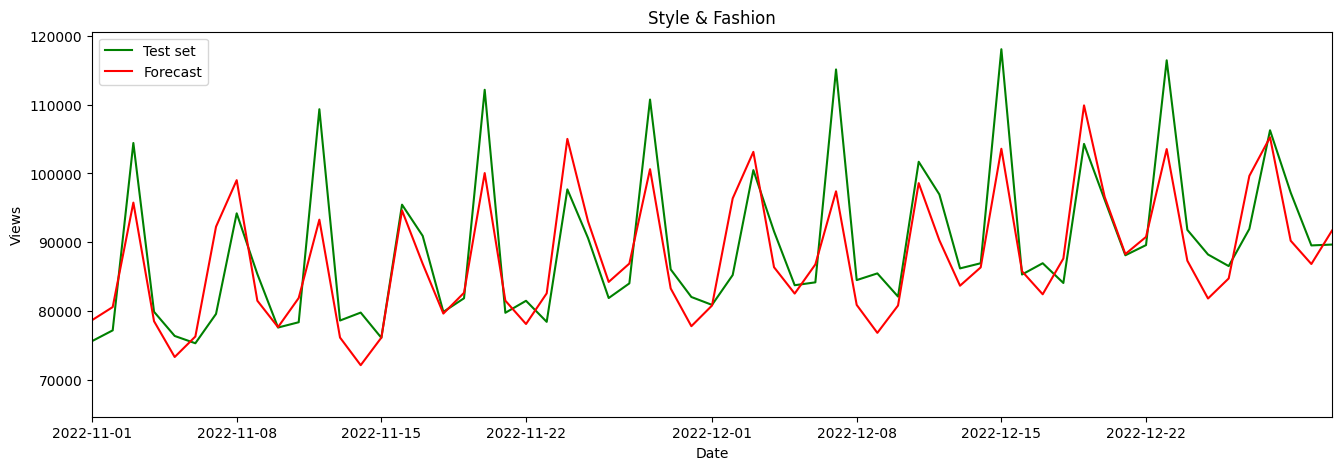

Epoch 1/20
232/232 [==============================] - 13s 38ms/step - loss: 0.0141 - mse: 0.0141 - mae: 0.0920 - mape: 24.8174
Epoch 2/20
232/232 [==============================] - 9s 37ms/step - loss: 0.0115 - mse: 0.0115 - mae: 0.0829 - mape: 21.6619
Epoch 3/20
232/232 [==============================] - 7s 32ms/step - loss: 0.0117 - mse: 0.0117 - mae: 0.0831 - mape: 21.1094
Epoch 4/20
232/232 [==============================] - 9s 38ms/step - loss: 0.0117 - mse: 0.0117 - mae: 0.0841 - mape: 21.8555
Epoch 5/20
232/232 [==============================] - 8s 33ms/step - loss: 0.0105 - mse: 0.0105 - mae: 0.0796 - mape: 20.5733
Epoch 6/20
232/232 [==============================] - 8s 33ms/step - loss: 0.0107 - mse: 0.0107 - mae: 0.0809 - mape: 21.2065
Epoch 7/20
232/232 [==============================] - 9s 38ms/step - loss: 0.0092 - mse: 0.0092 - mae: 0.0723 - mape: 18.2994
Epoch 8/20
232/232 [==============================] - 8s 33ms/step - loss: 0.0076 - mse: 0.0076 - mae: 0.0694 - mape:

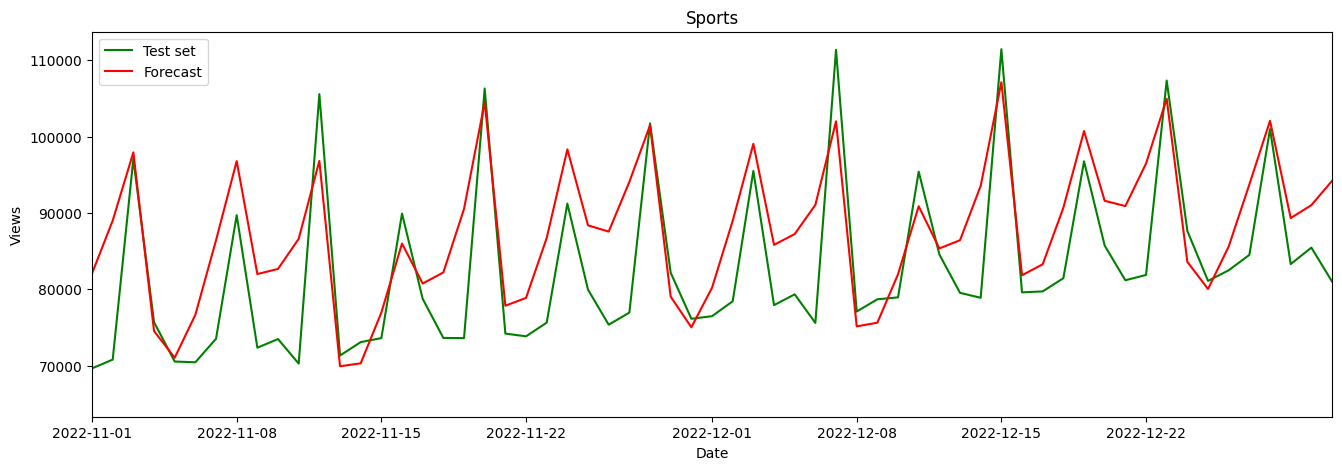

Epoch 1/20
232/232 [==============================] - 14s 34ms/step - loss: 0.0158 - mse: 0.0158 - mae: 0.0926 - mape: 25.6980
Epoch 2/20
232/232 [==============================] - 9s 40ms/step - loss: 0.0140 - mse: 0.0140 - mae: 0.0863 - mape: 22.8077
Epoch 3/20
232/232 [==============================] - 9s 40ms/step - loss: 0.0119 - mse: 0.0119 - mae: 0.0800 - mape: 21.6566
Epoch 4/20
232/232 [==============================] - 8s 34ms/step - loss: 0.0121 - mse: 0.0121 - mae: 0.0819 - mape: 21.9190
Epoch 5/20
232/232 [==============================] - 9s 39ms/step - loss: 0.0111 - mse: 0.0111 - mae: 0.0763 - mape: 19.7301
Epoch 6/20
232/232 [==============================] - 9s 39ms/step - loss: 0.0117 - mse: 0.0117 - mae: 0.0825 - mape: 22.0621
Epoch 7/20
232/232 [==============================] - 8s 34ms/step - loss: 0.0115 - mse: 0.0115 - mae: 0.0786 - mape: 20.6579
Epoch 8/20
232/232 [==============================] - 9s 38ms/step - loss: 0.0095 - mse: 0.0095 - mae: 0.0737 - mape:

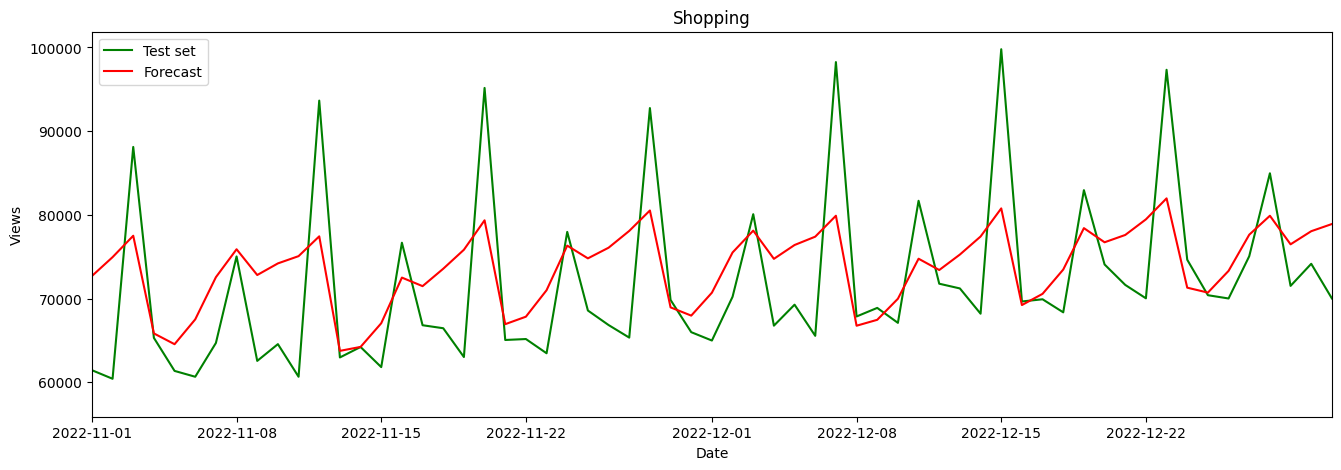

Epoch 1/20
232/232 [==============================] - 13s 34ms/step - loss: 0.0156 - mse: 0.0156 - mae: 0.0950 - mape: 25.9995
Epoch 2/20
232/232 [==============================] - 12s 50ms/step - loss: 0.0104 - mse: 0.0104 - mae: 0.0807 - mape: 21.7881
Epoch 3/20
232/232 [==============================] - 8s 35ms/step - loss: 0.0086 - mse: 0.0086 - mae: 0.0750 - mape: 20.2466
Epoch 4/20
232/232 [==============================] - 8s 36ms/step - loss: 0.0101 - mse: 0.0101 - mae: 0.0814 - mape: 21.0508
Epoch 5/20
232/232 [==============================] - 9s 37ms/step - loss: 0.0098 - mse: 0.0098 - mae: 0.0791 - mape: 21.0511
Epoch 6/20
232/232 [==============================] - 8s 33ms/step - loss: 0.0094 - mse: 0.0094 - mae: 0.0759 - mape: 19.8366
Epoch 7/20
232/232 [==============================] - 9s 38ms/step - loss: 0.0082 - mse: 0.0082 - mae: 0.0733 - mape: 19.0888
Epoch 8/20
232/232 [==============================] - 9s 38ms/step - loss: 0.0072 - mse: 0.0072 - mae: 0.0680 - mape

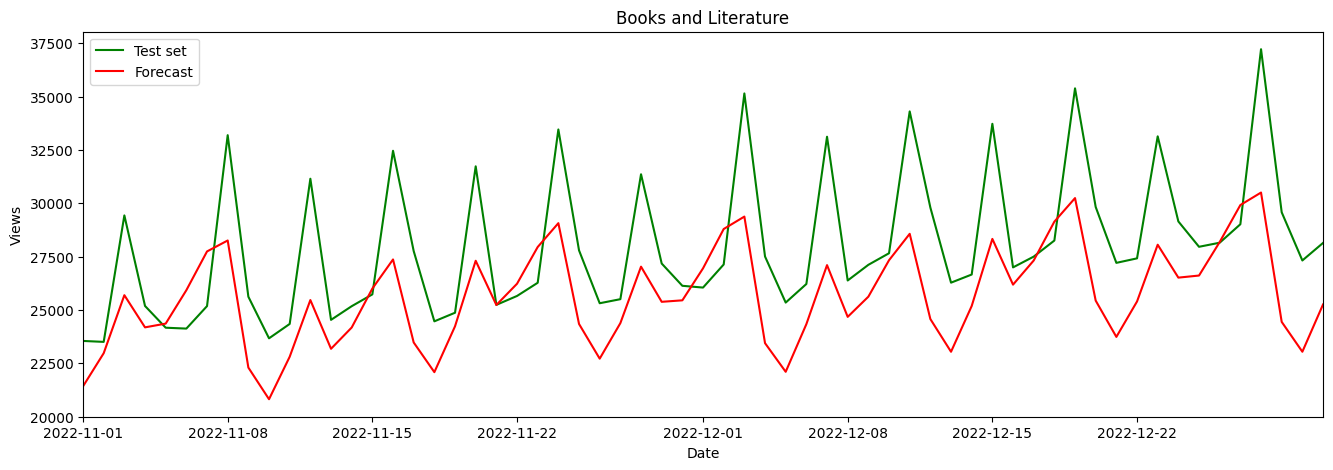

Epoch 1/20
232/232 [==============================] - 12s 38ms/step - loss: 0.0223 - mse: 0.0223 - mae: 0.1113 - mape: 34.0028
Epoch 2/20
232/232 [==============================] - 9s 38ms/step - loss: 0.0169 - mse: 0.0169 - mae: 0.1013 - mape: 29.9799
Epoch 3/20
232/232 [==============================] - 7s 32ms/step - loss: 0.0161 - mse: 0.0161 - mae: 0.0966 - mape: 29.3201
Epoch 4/20
232/232 [==============================] - 9s 38ms/step - loss: 0.0146 - mse: 0.0146 - mae: 0.0904 - mape: 27.3678
Epoch 5/20
232/232 [==============================] - 8s 34ms/step - loss: 0.0125 - mse: 0.0125 - mae: 0.0863 - mape: 25.7738
Epoch 6/20
232/232 [==============================] - 10s 42ms/step - loss: 0.0089 - mse: 0.0089 - mae: 0.0768 - mape: 23.4704
Epoch 7/20
232/232 [==============================] - 9s 38ms/step - loss: 0.0080 - mse: 0.0080 - mae: 0.0689 - mape: 20.7191
Epoch 8/20
232/232 [==============================] - 8s 34ms/step - loss: 0.0078 - mse: 0.0078 - mae: 0.0699 - mape

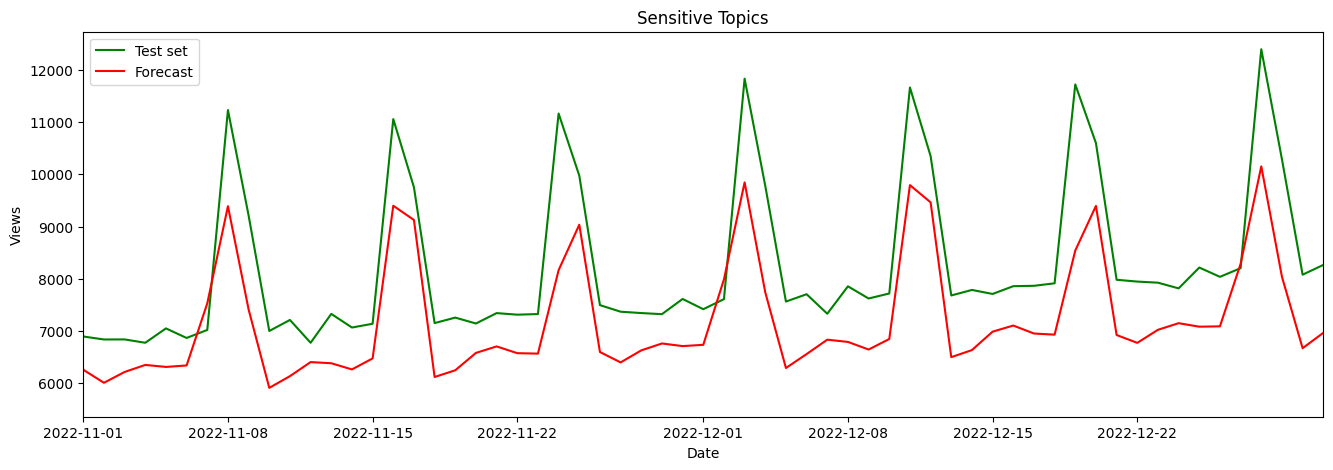

Epoch 1/20
232/232 [==============================] - 14s 39ms/step - loss: 0.0142 - mse: 0.0142 - mae: 0.0871 - mape: 22.9662
Epoch 2/20
232/232 [==============================] - 9s 39ms/step - loss: 0.0101 - mse: 0.0101 - mae: 0.0767 - mape: 19.9172
Epoch 3/20
232/232 [==============================] - 8s 35ms/step - loss: 0.0096 - mse: 0.0096 - mae: 0.0747 - mape: 18.9477
Epoch 4/20
232/232 [==============================] - 9s 40ms/step - loss: 0.0094 - mse: 0.0094 - mae: 0.0733 - mape: 19.2775
Epoch 5/20
232/232 [==============================] - 9s 39ms/step - loss: 0.0098 - mse: 0.0098 - mae: 0.0743 - mape: 18.9456
Epoch 6/20
232/232 [==============================] - 8s 35ms/step - loss: 0.0090 - mse: 0.0090 - mae: 0.0717 - mape: 18.5021
Epoch 7/20
232/232 [==============================] - 9s 40ms/step - loss: 0.0090 - mse: 0.0090 - mae: 0.0719 - mape: 18.1938
Epoch 8/20
232/232 [==============================] - 9s 39ms/step - loss: 0.0081 - mse: 0.0081 - mae: 0.0693 - mape:

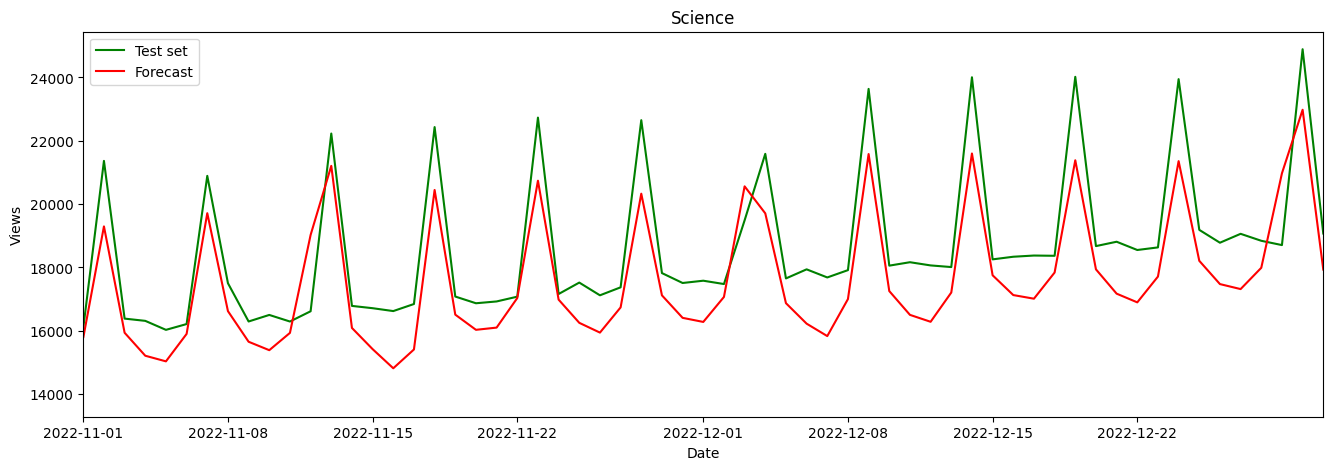

Epoch 1/20
232/232 [==============================] - 12s 36ms/step - loss: 0.0160 - mse: 0.0160 - mae: 0.1003 - mape: 27.9928
Epoch 2/20
232/232 [==============================] - 9s 38ms/step - loss: 0.0120 - mse: 0.0120 - mae: 0.0821 - mape: 21.2190
Epoch 3/20
232/232 [==============================] - 9s 40ms/step - loss: 0.0106 - mse: 0.0106 - mae: 0.0790 - mape: 21.7445
Epoch 4/20
232/232 [==============================] - 8s 34ms/step - loss: 0.0100 - mse: 0.0100 - mae: 0.0772 - mape: 20.4310
Epoch 5/20
232/232 [==============================] - 9s 40ms/step - loss: 0.0094 - mse: 0.0094 - mae: 0.0728 - mape: 18.5519
Epoch 6/20
232/232 [==============================] - 9s 39ms/step - loss: 0.0107 - mse: 0.0107 - mae: 0.0806 - mape: 21.2130
Epoch 7/20
232/232 [==============================] - 8s 35ms/step - loss: 0.0092 - mse: 0.0092 - mae: 0.0731 - mape: 19.0228
Epoch 8/20
232/232 [==============================] - 9s 40ms/step - loss: 0.0082 - mse: 0.0082 - mae: 0.0683 - mape:

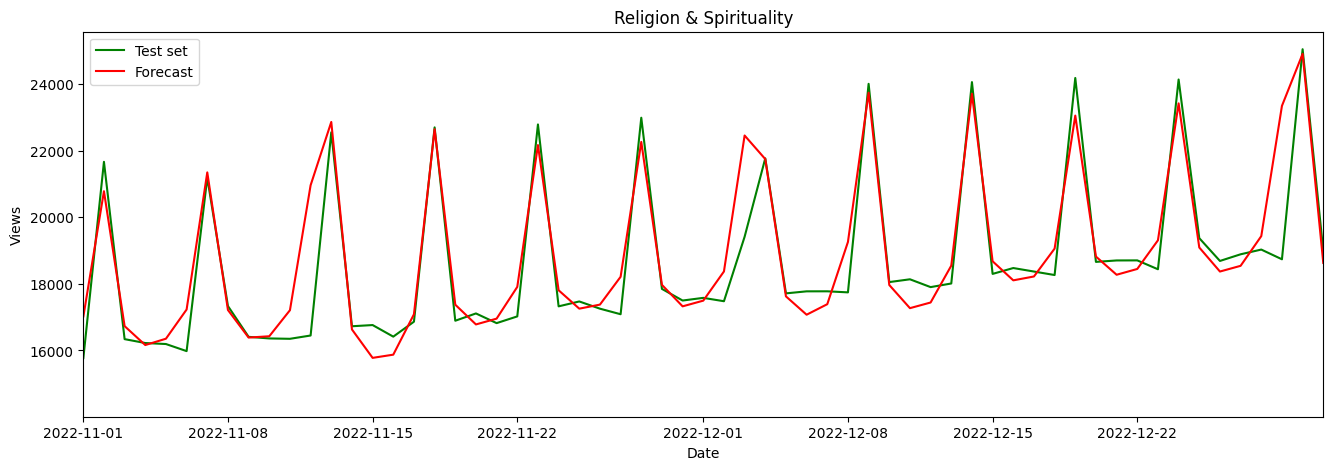

Epoch 1/20
232/232 [==============================] - 14s 46ms/step - loss: 0.0188 - mse: 0.0188 - mae: 0.0983 - mape: 28.4967
Epoch 2/20
232/232 [==============================] - 9s 39ms/step - loss: 0.0140 - mse: 0.0140 - mae: 0.0847 - mape: 23.9273
Epoch 3/20
232/232 [==============================] - 8s 32ms/step - loss: 0.0135 - mse: 0.0135 - mae: 0.0874 - mape: 24.3249
Epoch 4/20
232/232 [==============================] - 9s 41ms/step - loss: 0.0133 - mse: 0.0133 - mae: 0.0818 - mape: 22.6144
Epoch 5/20
232/232 [==============================] - 9s 38ms/step - loss: 0.0147 - mse: 0.0147 - mae: 0.0881 - mape: 24.5225
Epoch 6/20
232/232 [==============================] - 8s 35ms/step - loss: 0.0124 - mse: 0.0124 - mae: 0.0803 - mape: 22.2139
Epoch 7/20
232/232 [==============================] - 9s 40ms/step - loss: 0.0113 - mse: 0.0113 - mae: 0.0779 - mape: 20.7611
Epoch 8/20
232/232 [==============================] - 8s 34ms/step - loss: 0.0093 - mse: 0.0093 - mae: 0.0700 - mape:

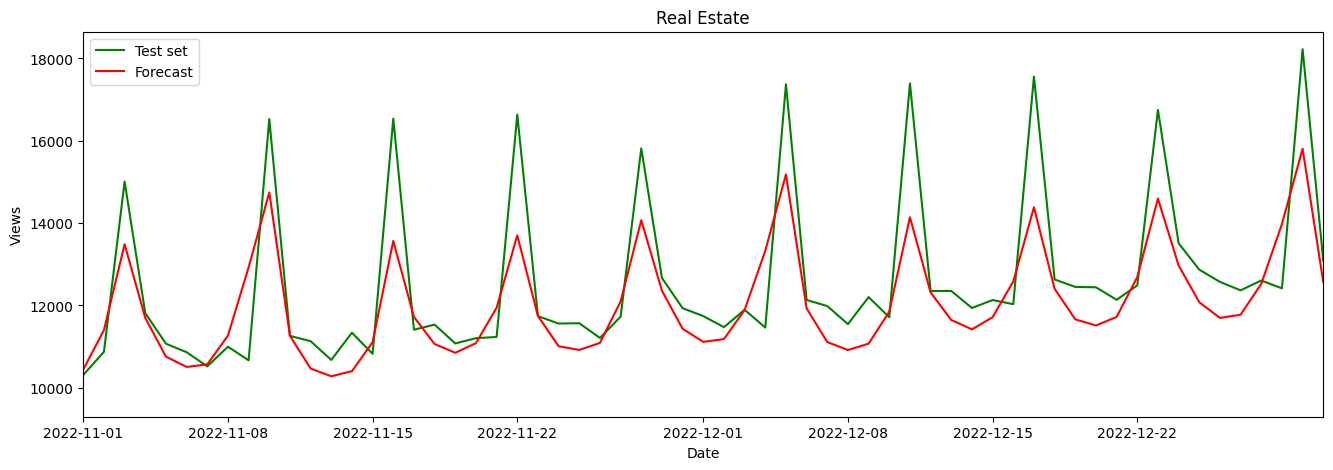

Epoch 1/20
205/205 [==============================] - 13s 37ms/step - loss: 0.0291 - mse: 0.0291 - mae: 0.1192 - mape: 40.1134
Epoch 2/20
205/205 [==============================] - 9s 43ms/step - loss: 0.0262 - mse: 0.0262 - mae: 0.1128 - mape: 37.1524
Epoch 3/20
205/205 [==============================] - 8s 41ms/step - loss: 0.0252 - mse: 0.0252 - mae: 0.1060 - mape: 33.4278
Epoch 4/20
205/205 [==============================] - 8s 38ms/step - loss: 0.0250 - mse: 0.0250 - mae: 0.1064 - mape: 34.1380
Epoch 5/20
205/205 [==============================] - 9s 43ms/step - loss: 0.0193 - mse: 0.0193 - mae: 0.0946 - mape: 29.3214
Epoch 6/20
205/205 [==============================] - 9s 43ms/step - loss: 0.0163 - mse: 0.0163 - mae: 0.0908 - mape: 29.9652
Epoch 7/20
205/205 [==============================] - 8s 41ms/step - loss: 0.0161 - mse: 0.0161 - mae: 0.0961 - mape: 33.6357
Epoch 8/20
205/205 [==============================] - 9s 42ms/step - loss: 0.0153 - mse: 0.0153 - mae: 0.0870 - mape:

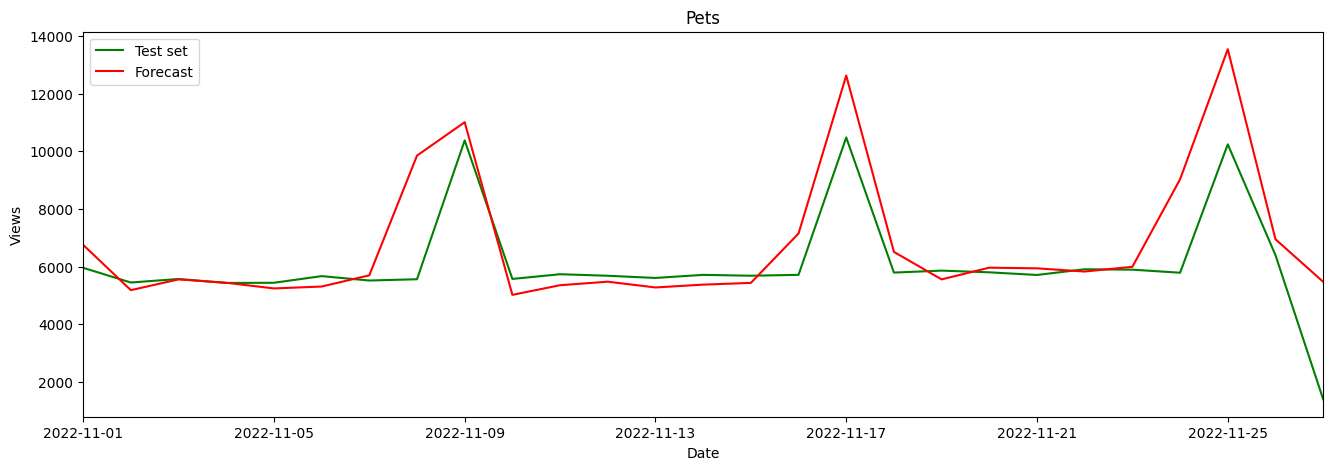

In [29]:
#Set best params for model
scaler = MinMaxScaler()

for segment in unique_segments:
    segment_data = datapoints_daily[datapoints_daily['segment_name'] == segment]
    segment_data_array = segment_data[['view_count']].values
    train_data_size = math.ceil(len(segment_data) * train_size)

    #Scale
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data_array = scaler.fit_transform(segment_data_array)
    #Create train dataset
    train_data = scaled_data_array[:train_data_size, :]

    X_train, y_train = [], []
    for i in range(60, len(train_data)):
         X_train.append(train_data[i-60:i, 0])
         y_train.append(train_data[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(units=25, activation='relu'))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae', 'mape'])
    model.fit(X_train, y_train, batch_size=1, epochs=20)

    #Create test dataset
    test_data_scaled = scaled_data_array[train_data_size-60:, :]
    test_data = segment_data_array[train_data_size-60:, :]

    #X and y data splitting:
    X_test = []
    y_test = []

    for i in range(60, len(test_data_scaled)):
        X_test.append(test_data_scaled[i-60:i, 0])
        y_test.append(test_data[i, 0])

    #Convert X_test and y_test to Numpy Array
    X_test, y_test = np.array(X_test), np.array(y_test)

    #Data dimension transformation
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    forecast_pred = model.predict(X_test)
    forecast_pred = scaler.inverse_transform(forecast_pred)

    #forecast_pred_transformed = np.round(forecast_pred,0)
    #forecast_pred_final = forecast_pred_transformed.astype(int)
    #test_data['Predictions'] = forecast_pred_final
    #datapoints_daily = pd.concat([test_data, forecast_pred_final])

    print(f"{calculate_metrics_for_model(y_test=y_test, predictions=forecast_pred)}")


    plt.figure(figsize=(16, 5))

    #Plot test values
    plt.plot(segment_data.time_index.values[train_data_size:], segment_data_array[train_data_size:],
            label='Test set', color='green')
    #Plot predictions
    plt.plot(segment_data.time_index.values[train_data_size:], forecast_pred,
            label='Forecast', color='red')

    plt.xlim([datetime(2022, 11, 1), segment_data.time_index.values[-1]])
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('Views')
    plt.title(f'{segment}')
    plt.savefig(f"LSTM_{segment}.png")

    plt.show()

#Conclusion

The data presented are for groups of people with common interests who viewed the site X times.

The challenge posed was to properly prepare the data and then analyze it and make a prediction for December 2022.

# **Seasonality**.

A noticeable seasonality can be observed. The data in Figures 1 and 2 show how directly proportional displays increase over the year. The trend is presented practically as a straight line.

# **Similarities**.

From the data received, it was necessary to separate those from Saturday and Sunday.

You can see the apparent similarities between the segments in Figure 3.

Technology & Computing, Travel, Style & Fashion, Sports, Shopping, Book and Literature are very close to each other in the charts.
This can be explained by the fact that these segments relate to our daily lives

A similar situation applies to Science and Religion & Spirituality, as well as Sensitive Topics about Pets - in the latter case the convergence is less.

The similarity between Science and Religion & Spirituality can be explained by the fact that these segments are somewhat similar to each other. Since time immemorial, science and religion have intersected and challenged each other's beliefs.

Real Estate has no data similarity.

### **Correlation**.

Correlation in Figure 4 occurs between all segments.

A Pearson coefficient of 0.991 indicates a very strong linear relationship, and a P-value < 0.05 in both (Destop and Mobile) cases says that the data are stastically significant

# **Prediction**.

ARIMA, SARIMA and LSTM were used as predictive models.
With such a large data set, LSTM performed best in this case. This is due to the fact that it retains long-term memory, can detect patterns among the data, can highlight many features or avoids the problem of disappearing gradient